# GM-VAE for SMBA, 8 components

In [1]:
num_epochs = 10000

## Import Libraries

In [2]:
import json

import numpy as np
import argparse
import random
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.utils.data
from scipy.io import loadmat

import sys
sys.path.append('/home/yangz2/projects/gmvae_and_gmmvae/pytorch/')
sys.path.append('../../1906-pcgml/pcgml-gmmVae-exp/modules/')
import vglc_with_path_encodings

from model.GMVAE import *
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Load data

In [3]:
def open_json_as_nparray(json_fname):
    with open(json_fname, 'r') as json_f:
        return np.array(json.load(json_f))

Load SMB.

In [4]:
smb_int = open_json_as_nparray('smbWithPath-allLevels-chunks-int.json')

In [5]:
smb_onehot = np.eye(len(np.unique(smb_int)))[smb_int]
smb_onehot.shape

(2698, 16, 16, 12)

In [6]:
smb_onehot = smb_onehot.reshape(
    smb_onehot.shape[0], 
    smb_onehot.shape[1] * smb_onehot.shape[2] * smb_onehot.shape[3]
)
smb_onehot.shape

(2698, 3072)

In [7]:
np.random.seed(42)
smb_labels = np.random.randint(8, size=smb_onehot.shape[0])
smb_labels.shape, smb_labels[:20]

((2698,), array([6, 3, 4, 6, 2, 7, 4, 4, 6, 1, 2, 6, 2, 2, 7, 4, 3, 7, 7, 2]))

In [8]:
chunks, labels = smb_onehot, smb_labels

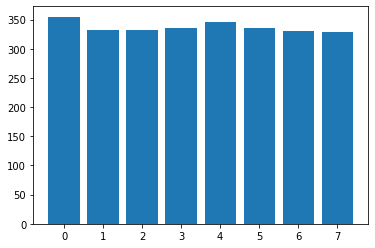

In [9]:
plt.bar(np.arange(8), np.bincount(smb_labels))
plt.show()

## Input Parameters

In [10]:
num_components = 8

In [11]:
########################################################
## Input Parameters
#########################################################
parser = argparse.ArgumentParser(description='PyTorch Implementation of DGM Clustering')

## Used only in notebooks
parser.add_argument('-f', '--file',
                    help='Path for input file. First line should contain number of lines to search in')

## Dataset
parser.add_argument('--dataset', type=str, choices=['mnist'],
                    default='mnist', help='dataset (default: mnist)')
parser.add_argument('--seed', type=int, default=1, help='random seed (default: 1)')

## GPU
parser.add_argument('--cuda', type=int, default=1,
                    help='use of cuda (default: 1)')
parser.add_argument('--gpuID', type=int, default=0,
                    help='set gpu id to use (default: 0)')

## Training
parser.add_argument('--epochs', type=int, default=num_epochs,
                    help='number of total epochs to run (default: 200)')
parser.add_argument('--batch_size', default=64, type=int,
                    help='mini-batch size (default: 64)')
parser.add_argument('--batch_size_val', default=200, type=int,
                    help='mini-batch size of validation (default: 200)')
parser.add_argument('--learning_rate', default=1e-3, type=float,
                    help='learning rate (default: 0.001)')
parser.add_argument('--decay_epoch', default=-1, type=int, 
                    help='Reduces the learning rate every decay_epoch')
parser.add_argument('--lr_decay', default=0.5, type=float,
                    help='Learning rate decay for training (default: 0.5)')

## Architecture
parser.add_argument('--num_classes', type=int, default=num_components,
                    help='number of classes (default: 10)')  # edited for this task
parser.add_argument('--gaussian_size', default=64, type=int,
                    help='gaussian size (default: 64)')
parser.add_argument('--input_size', default=3072, type=int,
                    help='input size (default: 784)')  # edited for this task

## Partition parameters
parser.add_argument('--train_proportion', default=0.9, type=float,
                    help='proportion of examples to consider for training only (default: 1.0)')

## Gumbel parameters
parser.add_argument('--init_temp', default=1.0, type=float,
                    help='Initial temperature used in gumbel-softmax (recommended 0.5-1.0, default:1.0)')
parser.add_argument('--decay_temp', default=1, type=int, 
                    help='Set 1 to decay gumbel temperature at every epoch (default: 1)')
parser.add_argument('--hard_gumbel', default=0, type=int, 
                    help='Set 1 to use the hard version of gumbel-softmax (default: 1)')
parser.add_argument('--min_temp', default=0.5, type=float, 
                    help='Minimum temperature of gumbel-softmax after annealing (default: 0.5)' )
parser.add_argument('--decay_temp_rate', default=0.013862944, type=float,
                    help='Temperature decay rate at every epoch (default: 0.013862944)')

## Loss function parameters
parser.add_argument('--w_gauss', default=2, type=float,
                    help='weight of gaussian loss (default: 1)')
parser.add_argument('--w_categ', default=1, type=float,
                    help='weight of categorical loss (default: 1)')
parser.add_argument('--w_rec', default=1, type=float,
                    help='weight of reconstruction loss (default: 1)')
parser.add_argument('--rec_type', type=str, choices=['bce', 'mse'],
                    default='bce', help='desired reconstruction loss function (default: bce)')

## Others
parser.add_argument('--verbose', default=0, type=int,
                    help='print extra information at every epoch.(default: 0)')

args = parser.parse_args()

Set random seed in case it was specified in the parameters


In [12]:
## Random Seed
SEED = args.seed
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
if args.cuda:
    torch.cuda.manual_seed(SEED)

## Data Partition

We split the training data into train and validation according to the *train_proportion* parameter:

In [13]:
from torch.utils.data import TensorDataset, DataLoader

In [14]:
assert args.train_proportion != 1

In [15]:
def partition_dataset(n, proportion=1):
   train_num = int(n * proportion)
   indices = np.random.permutation(n)
   train_indices, val_indices = indices[:train_num], indices[train_num:]
   return train_indices, val_indices

train_indices, val_indices = partition_dataset(len(chunks), args.train_proportion)
train_ds = TensorDataset(torch.from_numpy(chunks).float(), torch.from_numpy(labels).long())
train_dl = DataLoader(train_ds, batch_size=args.batch_size, sampler=SubsetRandomSampler(train_indices))
valid_dl = DataLoader(train_ds, batch_size=args.batch_size_val, sampler=SubsetRandomSampler(val_indices))

## Train Model

In [16]:
# Model Initialization
gmvae = GMVAE(args)

In [22]:
gmvae.train(train_dl, valid_dl)

(Epoch 1 / 10000) Train_Loss: 485.278; Val_Loss: 240.016   Train_ACC: 14.786; Val_ACC: 14.815   Train_NMI: 0.707; Val_NMI: 1.388
(Epoch 2 / 10000) Train_Loss: 230.533; Val_Loss: 227.010   Train_ACC: 14.415; Val_ACC: 15.185   Train_NMI: 0.408; Val_NMI: 0.375
(Epoch 3 / 10000) Train_Loss: 226.405; Val_Loss: 227.659   Train_ACC: 14.127; Val_ACC: 15.926   Train_NMI: 0.324; Val_NMI: 1.224
(Epoch 4 / 10000) Train_Loss: 222.295; Val_Loss: 225.466   Train_ACC: 14.662; Val_ACC: 17.778   Train_NMI: 0.610; Val_NMI: 2.965
(Epoch 5 / 10000) Train_Loss: 215.178; Val_Loss: 212.209   Train_ACC: 14.209; Val_ACC: 18.889   Train_NMI: 0.325; Val_NMI: 3.928
(Epoch 6 / 10000) Train_Loss: 210.584; Val_Loss: 212.660   Train_ACC: 13.880; Val_ACC: 15.556   Train_NMI: 0.424; Val_NMI: 1.081
(Epoch 7 / 10000) Train_Loss: 206.127; Val_Loss: 207.296   Train_ACC: 14.498; Val_ACC: 17.778   Train_NMI: 0.579; Val_NMI: 3.142
(Epoch 8 / 10000) Train_Loss: 202.711; Val_Loss: 198.676   Train_ACC: 14.044; Val_ACC: 19.630   T

(Epoch 65 / 10000) Train_Loss: 131.888; Val_Loss: 159.203   Train_ACC: 15.115; Val_ACC: 19.259   Train_NMI: 0.383; Val_NMI: 6.143
(Epoch 66 / 10000) Train_Loss: 131.928; Val_Loss: 163.298   Train_ACC: 15.198; Val_ACC: 18.519   Train_NMI: 0.469; Val_NMI: 5.199
(Epoch 67 / 10000) Train_Loss: 131.522; Val_Loss: 159.118   Train_ACC: 15.074; Val_ACC: 18.519   Train_NMI: 0.377; Val_NMI: 3.838
(Epoch 68 / 10000) Train_Loss: 130.011; Val_Loss: 160.355   Train_ACC: 14.951; Val_ACC: 19.259   Train_NMI: 0.455; Val_NMI: 5.394
(Epoch 69 / 10000) Train_Loss: 129.003; Val_Loss: 156.794   Train_ACC: 15.198; Val_ACC: 20.000   Train_NMI: 0.440; Val_NMI: 5.159
(Epoch 70 / 10000) Train_Loss: 128.258; Val_Loss: 158.752   Train_ACC: 15.033; Val_ACC: 19.259   Train_NMI: 0.397; Val_NMI: 5.684
(Epoch 71 / 10000) Train_Loss: 128.248; Val_Loss: 150.440   Train_ACC: 14.827; Val_ACC: 20.000   Train_NMI: 0.394; Val_NMI: 5.751
(Epoch 72 / 10000) Train_Loss: 126.921; Val_Loss: 155.730   Train_ACC: 14.580; Val_ACC: 20

(Epoch 128 / 10000) Train_Loss: 92.263; Val_Loss: 181.293   Train_ACC: 15.074; Val_ACC: 19.259   Train_NMI: 0.425; Val_NMI: 5.086
(Epoch 129 / 10000) Train_Loss: 91.838; Val_Loss: 182.697   Train_ACC: 14.909; Val_ACC: 20.000   Train_NMI: 0.403; Val_NMI: 4.755
(Epoch 130 / 10000) Train_Loss: 92.923; Val_Loss: 177.794   Train_ACC: 14.909; Val_ACC: 20.370   Train_NMI: 0.394; Val_NMI: 4.823
(Epoch 131 / 10000) Train_Loss: 92.354; Val_Loss: 179.809   Train_ACC: 15.568; Val_ACC: 20.370   Train_NMI: 0.472; Val_NMI: 4.872
(Epoch 132 / 10000) Train_Loss: 91.087; Val_Loss: 182.543   Train_ACC: 15.157; Val_ACC: 20.741   Train_NMI: 0.413; Val_NMI: 5.096
(Epoch 133 / 10000) Train_Loss: 90.111; Val_Loss: 180.490   Train_ACC: 14.827; Val_ACC: 20.370   Train_NMI: 0.340; Val_NMI: 5.761
(Epoch 134 / 10000) Train_Loss: 89.185; Val_Loss: 182.536   Train_ACC: 15.074; Val_ACC: 20.000   Train_NMI: 0.459; Val_NMI: 4.718
(Epoch 135 / 10000) Train_Loss: 88.756; Val_Loss: 184.611   Train_ACC: 15.239; Val_ACC: 20

(Epoch 192 / 10000) Train_Loss: 68.213; Val_Loss: 242.640   Train_ACC: 15.033; Val_ACC: 19.630   Train_NMI: 0.405; Val_NMI: 4.446
(Epoch 193 / 10000) Train_Loss: 69.653; Val_Loss: 247.628   Train_ACC: 14.745; Val_ACC: 18.889   Train_NMI: 0.381; Val_NMI: 4.194
(Epoch 194 / 10000) Train_Loss: 70.400; Val_Loss: 249.313   Train_ACC: 14.951; Val_ACC: 19.259   Train_NMI: 0.430; Val_NMI: 4.450
(Epoch 195 / 10000) Train_Loss: 68.442; Val_Loss: 247.511   Train_ACC: 15.239; Val_ACC: 19.259   Train_NMI: 0.454; Val_NMI: 4.613
(Epoch 196 / 10000) Train_Loss: 67.712; Val_Loss: 259.629   Train_ACC: 14.909; Val_ACC: 20.000   Train_NMI: 0.347; Val_NMI: 4.855
(Epoch 197 / 10000) Train_Loss: 68.229; Val_Loss: 260.737   Train_ACC: 14.868; Val_ACC: 19.259   Train_NMI: 0.356; Val_NMI: 4.117
(Epoch 198 / 10000) Train_Loss: 67.056; Val_Loss: 248.536   Train_ACC: 14.703; Val_ACC: 19.630   Train_NMI: 0.323; Val_NMI: 5.207
(Epoch 199 / 10000) Train_Loss: 66.550; Val_Loss: 256.884   Train_ACC: 14.868; Val_ACC: 19

(Epoch 256 / 10000) Train_Loss: 56.664; Val_Loss: 335.167   Train_ACC: 14.951; Val_ACC: 20.000   Train_NMI: 0.449; Val_NMI: 4.758
(Epoch 257 / 10000) Train_Loss: 56.761; Val_Loss: 324.367   Train_ACC: 14.621; Val_ACC: 19.630   Train_NMI: 0.329; Val_NMI: 4.646
(Epoch 258 / 10000) Train_Loss: 56.556; Val_Loss: 317.353   Train_ACC: 14.539; Val_ACC: 20.000   Train_NMI: 0.309; Val_NMI: 4.839
(Epoch 259 / 10000) Train_Loss: 56.854; Val_Loss: 331.782   Train_ACC: 14.786; Val_ACC: 20.000   Train_NMI: 0.377; Val_NMI: 4.534
(Epoch 260 / 10000) Train_Loss: 56.191; Val_Loss: 322.213   Train_ACC: 14.621; Val_ACC: 20.000   Train_NMI: 0.315; Val_NMI: 4.683
(Epoch 261 / 10000) Train_Loss: 55.724; Val_Loss: 331.254   Train_ACC: 14.909; Val_ACC: 19.630   Train_NMI: 0.315; Val_NMI: 4.939
(Epoch 262 / 10000) Train_Loss: 54.768; Val_Loss: 320.391   Train_ACC: 14.786; Val_ACC: 19.630   Train_NMI: 0.335; Val_NMI: 4.693
(Epoch 263 / 10000) Train_Loss: 55.794; Val_Loss: 343.088   Train_ACC: 14.868; Val_ACC: 19

(Epoch 320 / 10000) Train_Loss: 49.030; Val_Loss: 377.318   Train_ACC: 14.580; Val_ACC: 20.000   Train_NMI: 0.350; Val_NMI: 4.700
(Epoch 321 / 10000) Train_Loss: 49.461; Val_Loss: 398.126   Train_ACC: 14.827; Val_ACC: 20.370   Train_NMI: 0.371; Val_NMI: 5.456
(Epoch 322 / 10000) Train_Loss: 48.684; Val_Loss: 370.624   Train_ACC: 14.909; Val_ACC: 19.630   Train_NMI: 0.393; Val_NMI: 4.204
(Epoch 323 / 10000) Train_Loss: 47.931; Val_Loss: 403.398   Train_ACC: 14.703; Val_ACC: 20.741   Train_NMI: 0.314; Val_NMI: 5.632
(Epoch 324 / 10000) Train_Loss: 48.238; Val_Loss: 390.438   Train_ACC: 14.868; Val_ACC: 19.630   Train_NMI: 0.387; Val_NMI: 4.595
(Epoch 325 / 10000) Train_Loss: 49.658; Val_Loss: 396.127   Train_ACC: 14.992; Val_ACC: 20.000   Train_NMI: 0.416; Val_NMI: 5.693
(Epoch 326 / 10000) Train_Loss: 49.280; Val_Loss: 409.767   Train_ACC: 14.827; Val_ACC: 19.630   Train_NMI: 0.385; Val_NMI: 4.914
(Epoch 327 / 10000) Train_Loss: 49.809; Val_Loss: 387.810   Train_ACC: 15.074; Val_ACC: 19

(Epoch 384 / 10000) Train_Loss: 45.814; Val_Loss: 443.810   Train_ACC: 14.827; Val_ACC: 19.630   Train_NMI: 0.459; Val_NMI: 5.047
(Epoch 385 / 10000) Train_Loss: 45.353; Val_Loss: 459.485   Train_ACC: 14.786; Val_ACC: 18.519   Train_NMI: 0.349; Val_NMI: 4.469
(Epoch 386 / 10000) Train_Loss: 43.694; Val_Loss: 457.357   Train_ACC: 14.951; Val_ACC: 19.259   Train_NMI: 0.411; Val_NMI: 4.559
(Epoch 387 / 10000) Train_Loss: 43.723; Val_Loss: 463.782   Train_ACC: 14.827; Val_ACC: 19.259   Train_NMI: 0.421; Val_NMI: 4.866
(Epoch 388 / 10000) Train_Loss: 44.876; Val_Loss: 449.942   Train_ACC: 14.909; Val_ACC: 19.259   Train_NMI: 0.374; Val_NMI: 4.103
(Epoch 389 / 10000) Train_Loss: 43.442; Val_Loss: 456.150   Train_ACC: 14.827; Val_ACC: 19.630   Train_NMI: 0.397; Val_NMI: 4.990
(Epoch 390 / 10000) Train_Loss: 43.756; Val_Loss: 443.855   Train_ACC: 14.909; Val_ACC: 19.259   Train_NMI: 0.311; Val_NMI: 5.017
(Epoch 391 / 10000) Train_Loss: 43.841; Val_Loss: 466.655   Train_ACC: 14.827; Val_ACC: 19

(Epoch 448 / 10000) Train_Loss: 39.192; Val_Loss: 479.908   Train_ACC: 15.033; Val_ACC: 20.000   Train_NMI: 0.426; Val_NMI: 5.125
(Epoch 449 / 10000) Train_Loss: 39.718; Val_Loss: 482.839   Train_ACC: 14.951; Val_ACC: 20.741   Train_NMI: 0.401; Val_NMI: 5.490
(Epoch 450 / 10000) Train_Loss: 39.682; Val_Loss: 510.555   Train_ACC: 14.868; Val_ACC: 19.630   Train_NMI: 0.402; Val_NMI: 5.623
(Epoch 451 / 10000) Train_Loss: 39.167; Val_Loss: 482.701   Train_ACC: 15.074; Val_ACC: 19.630   Train_NMI: 0.413; Val_NMI: 4.789
(Epoch 452 / 10000) Train_Loss: 39.473; Val_Loss: 520.500   Train_ACC: 14.992; Val_ACC: 21.111   Train_NMI: 0.391; Val_NMI: 5.778
(Epoch 453 / 10000) Train_Loss: 39.911; Val_Loss: 522.559   Train_ACC: 15.074; Val_ACC: 19.259   Train_NMI: 0.439; Val_NMI: 4.827
(Epoch 454 / 10000) Train_Loss: 40.771; Val_Loss: 488.991   Train_ACC: 14.992; Val_ACC: 19.630   Train_NMI: 0.390; Val_NMI: 4.877
(Epoch 455 / 10000) Train_Loss: 41.454; Val_Loss: 505.946   Train_ACC: 14.868; Val_ACC: 19

(Epoch 512 / 10000) Train_Loss: 43.770; Val_Loss: 536.394   Train_ACC: 15.157; Val_ACC: 19.630   Train_NMI: 0.418; Val_NMI: 4.135
(Epoch 513 / 10000) Train_Loss: 40.487; Val_Loss: 471.492   Train_ACC: 15.198; Val_ACC: 19.630   Train_NMI: 0.491; Val_NMI: 4.635
(Epoch 514 / 10000) Train_Loss: 38.746; Val_Loss: 538.748   Train_ACC: 14.909; Val_ACC: 20.741   Train_NMI: 0.425; Val_NMI: 4.929
(Epoch 515 / 10000) Train_Loss: 37.905; Val_Loss: 551.176   Train_ACC: 15.033; Val_ACC: 20.000   Train_NMI: 0.438; Val_NMI: 4.603
(Epoch 516 / 10000) Train_Loss: 37.797; Val_Loss: 564.235   Train_ACC: 14.909; Val_ACC: 19.259   Train_NMI: 0.413; Val_NMI: 4.256
(Epoch 517 / 10000) Train_Loss: 41.660; Val_Loss: 533.889   Train_ACC: 14.951; Val_ACC: 19.630   Train_NMI: 0.385; Val_NMI: 4.499
(Epoch 518 / 10000) Train_Loss: 40.837; Val_Loss: 545.583   Train_ACC: 15.157; Val_ACC: 20.370   Train_NMI: 0.386; Val_NMI: 4.525
(Epoch 519 / 10000) Train_Loss: 40.230; Val_Loss: 544.765   Train_ACC: 14.951; Val_ACC: 19

(Epoch 576 / 10000) Train_Loss: 38.237; Val_Loss: 588.757   Train_ACC: 15.115; Val_ACC: 19.630   Train_NMI: 0.470; Val_NMI: 5.016
(Epoch 577 / 10000) Train_Loss: 37.986; Val_Loss: 567.740   Train_ACC: 15.115; Val_ACC: 20.000   Train_NMI: 0.399; Val_NMI: 5.127
(Epoch 578 / 10000) Train_Loss: 36.369; Val_Loss: 582.193   Train_ACC: 14.992; Val_ACC: 20.370   Train_NMI: 0.398; Val_NMI: 5.085
(Epoch 579 / 10000) Train_Loss: 36.998; Val_Loss: 587.234   Train_ACC: 14.951; Val_ACC: 20.370   Train_NMI: 0.386; Val_NMI: 4.914
(Epoch 580 / 10000) Train_Loss: 38.411; Val_Loss: 606.255   Train_ACC: 14.868; Val_ACC: 20.000   Train_NMI: 0.404; Val_NMI: 4.751
(Epoch 581 / 10000) Train_Loss: 38.215; Val_Loss: 574.783   Train_ACC: 14.827; Val_ACC: 19.630   Train_NMI: 0.365; Val_NMI: 5.019
(Epoch 582 / 10000) Train_Loss: 36.887; Val_Loss: 554.335   Train_ACC: 14.745; Val_ACC: 20.000   Train_NMI: 0.372; Val_NMI: 4.835
(Epoch 583 / 10000) Train_Loss: 36.293; Val_Loss: 621.974   Train_ACC: 14.786; Val_ACC: 20

(Epoch 640 / 10000) Train_Loss: 36.350; Val_Loss: 589.760   Train_ACC: 14.909; Val_ACC: 20.370   Train_NMI: 0.449; Val_NMI: 5.396
(Epoch 641 / 10000) Train_Loss: 36.449; Val_Loss: 620.770   Train_ACC: 14.786; Val_ACC: 19.630   Train_NMI: 0.462; Val_NMI: 4.892
(Epoch 642 / 10000) Train_Loss: 35.209; Val_Loss: 589.677   Train_ACC: 14.786; Val_ACC: 20.000   Train_NMI: 0.378; Val_NMI: 5.559
(Epoch 643 / 10000) Train_Loss: 36.614; Val_Loss: 591.616   Train_ACC: 14.703; Val_ACC: 20.000   Train_NMI: 0.360; Val_NMI: 4.747
(Epoch 644 / 10000) Train_Loss: 37.111; Val_Loss: 634.388   Train_ACC: 14.868; Val_ACC: 20.000   Train_NMI: 0.417; Val_NMI: 4.646
(Epoch 645 / 10000) Train_Loss: 35.815; Val_Loss: 625.824   Train_ACC: 14.992; Val_ACC: 20.741   Train_NMI: 0.380; Val_NMI: 5.447
(Epoch 646 / 10000) Train_Loss: 36.470; Val_Loss: 602.637   Train_ACC: 14.909; Val_ACC: 20.000   Train_NMI: 0.375; Val_NMI: 4.414
(Epoch 647 / 10000) Train_Loss: 35.801; Val_Loss: 644.317   Train_ACC: 14.745; Val_ACC: 20

(Epoch 704 / 10000) Train_Loss: 34.730; Val_Loss: 641.557   Train_ACC: 14.868; Val_ACC: 20.741   Train_NMI: 0.393; Val_NMI: 5.456
(Epoch 705 / 10000) Train_Loss: 34.650; Val_Loss: 615.843   Train_ACC: 14.745; Val_ACC: 21.111   Train_NMI: 0.343; Val_NMI: 6.214
(Epoch 706 / 10000) Train_Loss: 34.758; Val_Loss: 618.626   Train_ACC: 14.786; Val_ACC: 21.111   Train_NMI: 0.347; Val_NMI: 5.482
(Epoch 707 / 10000) Train_Loss: 35.738; Val_Loss: 643.731   Train_ACC: 14.745; Val_ACC: 20.370   Train_NMI: 0.364; Val_NMI: 5.202
(Epoch 708 / 10000) Train_Loss: 34.522; Val_Loss: 597.028   Train_ACC: 14.621; Val_ACC: 20.741   Train_NMI: 0.339; Val_NMI: 5.731
(Epoch 709 / 10000) Train_Loss: 33.961; Val_Loss: 635.531   Train_ACC: 14.745; Val_ACC: 21.111   Train_NMI: 0.383; Val_NMI: 5.208
(Epoch 710 / 10000) Train_Loss: 34.825; Val_Loss: 694.623   Train_ACC: 14.951; Val_ACC: 20.370   Train_NMI: 0.430; Val_NMI: 5.352
(Epoch 711 / 10000) Train_Loss: 35.868; Val_Loss: 676.336   Train_ACC: 15.280; Val_ACC: 20

(Epoch 768 / 10000) Train_Loss: 35.734; Val_Loss: 673.986   Train_ACC: 14.827; Val_ACC: 19.259   Train_NMI: 0.384; Val_NMI: 4.866
(Epoch 769 / 10000) Train_Loss: 35.936; Val_Loss: 659.613   Train_ACC: 14.662; Val_ACC: 20.000   Train_NMI: 0.355; Val_NMI: 5.500
(Epoch 770 / 10000) Train_Loss: 35.689; Val_Loss: 677.814   Train_ACC: 14.621; Val_ACC: 19.630   Train_NMI: 0.353; Val_NMI: 5.276
(Epoch 771 / 10000) Train_Loss: 35.260; Val_Loss: 686.287   Train_ACC: 14.868; Val_ACC: 20.000   Train_NMI: 0.362; Val_NMI: 5.627
(Epoch 772 / 10000) Train_Loss: 34.499; Val_Loss: 654.906   Train_ACC: 14.951; Val_ACC: 19.630   Train_NMI: 0.384; Val_NMI: 5.278
(Epoch 773 / 10000) Train_Loss: 34.279; Val_Loss: 676.237   Train_ACC: 14.745; Val_ACC: 18.889   Train_NMI: 0.411; Val_NMI: 4.465
(Epoch 774 / 10000) Train_Loss: 33.564; Val_Loss: 686.119   Train_ACC: 14.703; Val_ACC: 20.000   Train_NMI: 0.340; Val_NMI: 5.011
(Epoch 775 / 10000) Train_Loss: 33.449; Val_Loss: 679.064   Train_ACC: 14.745; Val_ACC: 20

(Epoch 832 / 10000) Train_Loss: 33.494; Val_Loss: 683.297   Train_ACC: 14.868; Val_ACC: 20.370   Train_NMI: 0.391; Val_NMI: 5.479
(Epoch 833 / 10000) Train_Loss: 32.508; Val_Loss: 707.742   Train_ACC: 14.621; Val_ACC: 20.370   Train_NMI: 0.355; Val_NMI: 5.595
(Epoch 834 / 10000) Train_Loss: 32.148; Val_Loss: 675.259   Train_ACC: 14.786; Val_ACC: 20.370   Train_NMI: 0.340; Val_NMI: 4.930
(Epoch 835 / 10000) Train_Loss: 31.922; Val_Loss: 690.953   Train_ACC: 14.580; Val_ACC: 20.370   Train_NMI: 0.341; Val_NMI: 5.120
(Epoch 836 / 10000) Train_Loss: 31.984; Val_Loss: 712.228   Train_ACC: 14.662; Val_ACC: 20.000   Train_NMI: 0.354; Val_NMI: 4.388
(Epoch 837 / 10000) Train_Loss: 32.044; Val_Loss: 727.678   Train_ACC: 14.786; Val_ACC: 19.630   Train_NMI: 0.344; Val_NMI: 5.472
(Epoch 838 / 10000) Train_Loss: 33.229; Val_Loss: 660.265   Train_ACC: 14.786; Val_ACC: 20.000   Train_NMI: 0.350; Val_NMI: 5.208
(Epoch 839 / 10000) Train_Loss: 32.950; Val_Loss: 658.960   Train_ACC: 14.703; Val_ACC: 20

(Epoch 896 / 10000) Train_Loss: 33.274; Val_Loss: 715.289   Train_ACC: 14.786; Val_ACC: 19.630   Train_NMI: 0.366; Val_NMI: 4.754
(Epoch 897 / 10000) Train_Loss: 32.366; Val_Loss: 674.793   Train_ACC: 14.868; Val_ACC: 20.370   Train_NMI: 0.423; Val_NMI: 5.609
(Epoch 898 / 10000) Train_Loss: 32.210; Val_Loss: 683.376   Train_ACC: 14.662; Val_ACC: 19.630   Train_NMI: 0.386; Val_NMI: 4.966
(Epoch 899 / 10000) Train_Loss: 33.583; Val_Loss: 691.879   Train_ACC: 14.909; Val_ACC: 20.370   Train_NMI: 0.384; Val_NMI: 5.709
(Epoch 900 / 10000) Train_Loss: 33.999; Val_Loss: 690.517   Train_ACC: 14.992; Val_ACC: 20.370   Train_NMI: 0.437; Val_NMI: 5.522
(Epoch 901 / 10000) Train_Loss: 33.691; Val_Loss: 701.255   Train_ACC: 14.827; Val_ACC: 19.630   Train_NMI: 0.383; Val_NMI: 5.402
(Epoch 902 / 10000) Train_Loss: 36.229; Val_Loss: 706.340   Train_ACC: 15.033; Val_ACC: 19.630   Train_NMI: 0.406; Val_NMI: 5.061
(Epoch 903 / 10000) Train_Loss: 32.903; Val_Loss: 701.852   Train_ACC: 14.662; Val_ACC: 19

(Epoch 960 / 10000) Train_Loss: 32.185; Val_Loss: 744.629   Train_ACC: 14.786; Val_ACC: 20.370   Train_NMI: 0.396; Val_NMI: 4.864
(Epoch 961 / 10000) Train_Loss: 38.785; Val_Loss: 716.138   Train_ACC: 14.703; Val_ACC: 20.370   Train_NMI: 0.422; Val_NMI: 4.636
(Epoch 962 / 10000) Train_Loss: 38.172; Val_Loss: 734.236   Train_ACC: 14.786; Val_ACC: 18.889   Train_NMI: 0.446; Val_NMI: 4.544
(Epoch 963 / 10000) Train_Loss: 35.074; Val_Loss: 721.873   Train_ACC: 14.868; Val_ACC: 18.889   Train_NMI: 0.444; Val_NMI: 4.684
(Epoch 964 / 10000) Train_Loss: 33.282; Val_Loss: 777.465   Train_ACC: 14.868; Val_ACC: 19.259   Train_NMI: 0.427; Val_NMI: 4.682
(Epoch 965 / 10000) Train_Loss: 34.063; Val_Loss: 720.563   Train_ACC: 15.157; Val_ACC: 20.000   Train_NMI: 0.474; Val_NMI: 5.415
(Epoch 966 / 10000) Train_Loss: 33.435; Val_Loss: 717.967   Train_ACC: 14.703; Val_ACC: 19.630   Train_NMI: 0.381; Val_NMI: 5.254
(Epoch 967 / 10000) Train_Loss: 34.667; Val_Loss: 745.929   Train_ACC: 14.703; Val_ACC: 20

(Epoch 1023 / 10000) Train_Loss: 34.669; Val_Loss: 755.597   Train_ACC: 14.539; Val_ACC: 20.370   Train_NMI: 0.339; Val_NMI: 5.030
(Epoch 1024 / 10000) Train_Loss: 31.986; Val_Loss: 737.097   Train_ACC: 14.951; Val_ACC: 20.741   Train_NMI: 0.426; Val_NMI: 5.332
(Epoch 1025 / 10000) Train_Loss: 31.213; Val_Loss: 738.641   Train_ACC: 14.868; Val_ACC: 19.630   Train_NMI: 0.381; Val_NMI: 5.227
(Epoch 1026 / 10000) Train_Loss: 30.693; Val_Loss: 752.221   Train_ACC: 14.827; Val_ACC: 20.000   Train_NMI: 0.401; Val_NMI: 4.728
(Epoch 1027 / 10000) Train_Loss: 31.168; Val_Loss: 768.098   Train_ACC: 14.827; Val_ACC: 20.370   Train_NMI: 0.423; Val_NMI: 5.179
(Epoch 1028 / 10000) Train_Loss: 30.771; Val_Loss: 754.330   Train_ACC: 14.909; Val_ACC: 20.741   Train_NMI: 0.400; Val_NMI: 5.765
(Epoch 1029 / 10000) Train_Loss: 31.168; Val_Loss: 697.178   Train_ACC: 14.827; Val_ACC: 20.370   Train_NMI: 0.400; Val_NMI: 5.129
(Epoch 1030 / 10000) Train_Loss: 31.354; Val_Loss: 736.190   Train_ACC: 14.703; Val

(Epoch 1086 / 10000) Train_Loss: 32.770; Val_Loss: 744.389   Train_ACC: 15.115; Val_ACC: 21.481   Train_NMI: 0.441; Val_NMI: 5.906
(Epoch 1087 / 10000) Train_Loss: 32.233; Val_Loss: 737.119   Train_ACC: 14.909; Val_ACC: 19.259   Train_NMI: 0.359; Val_NMI: 4.225
(Epoch 1088 / 10000) Train_Loss: 31.822; Val_Loss: 745.847   Train_ACC: 14.868; Val_ACC: 20.370   Train_NMI: 0.411; Val_NMI: 5.547
(Epoch 1089 / 10000) Train_Loss: 32.073; Val_Loss: 798.839   Train_ACC: 14.745; Val_ACC: 20.000   Train_NMI: 0.391; Val_NMI: 5.942
(Epoch 1090 / 10000) Train_Loss: 31.589; Val_Loss: 772.479   Train_ACC: 14.992; Val_ACC: 20.000   Train_NMI: 0.406; Val_NMI: 5.377
(Epoch 1091 / 10000) Train_Loss: 31.821; Val_Loss: 743.656   Train_ACC: 14.868; Val_ACC: 20.000   Train_NMI: 0.398; Val_NMI: 4.886
(Epoch 1092 / 10000) Train_Loss: 32.129; Val_Loss: 763.589   Train_ACC: 14.992; Val_ACC: 19.630   Train_NMI: 0.395; Val_NMI: 5.213
(Epoch 1093 / 10000) Train_Loss: 33.659; Val_Loss: 773.901   Train_ACC: 14.827; Val

(Epoch 1149 / 10000) Train_Loss: 31.732; Val_Loss: 809.635   Train_ACC: 14.745; Val_ACC: 20.741   Train_NMI: 0.419; Val_NMI: 5.749
(Epoch 1150 / 10000) Train_Loss: 30.379; Val_Loss: 765.362   Train_ACC: 14.909; Val_ACC: 20.741   Train_NMI: 0.432; Val_NMI: 5.523
(Epoch 1151 / 10000) Train_Loss: 29.988; Val_Loss: 726.924   Train_ACC: 14.868; Val_ACC: 20.000   Train_NMI: 0.381; Val_NMI: 5.404
(Epoch 1152 / 10000) Train_Loss: 29.793; Val_Loss: 772.663   Train_ACC: 14.703; Val_ACC: 20.370   Train_NMI: 0.380; Val_NMI: 5.222
(Epoch 1153 / 10000) Train_Loss: 31.633; Val_Loss: 779.229   Train_ACC: 14.786; Val_ACC: 21.481   Train_NMI: 0.354; Val_NMI: 6.285
(Epoch 1154 / 10000) Train_Loss: 31.111; Val_Loss: 785.514   Train_ACC: 14.662; Val_ACC: 20.370   Train_NMI: 0.352; Val_NMI: 5.619
(Epoch 1155 / 10000) Train_Loss: 31.834; Val_Loss: 779.690   Train_ACC: 14.745; Val_ACC: 21.111   Train_NMI: 0.361; Val_NMI: 6.061
(Epoch 1156 / 10000) Train_Loss: 32.557; Val_Loss: 819.808   Train_ACC: 14.909; Val

(Epoch 1212 / 10000) Train_Loss: 30.027; Val_Loss: 815.786   Train_ACC: 14.868; Val_ACC: 20.741   Train_NMI: 0.409; Val_NMI: 6.028
(Epoch 1213 / 10000) Train_Loss: 29.114; Val_Loss: 764.411   Train_ACC: 14.662; Val_ACC: 19.259   Train_NMI: 0.382; Val_NMI: 4.970
(Epoch 1214 / 10000) Train_Loss: 30.153; Val_Loss: 770.504   Train_ACC: 14.703; Val_ACC: 20.370   Train_NMI: 0.364; Val_NMI: 5.459
(Epoch 1215 / 10000) Train_Loss: 32.366; Val_Loss: 790.480   Train_ACC: 14.909; Val_ACC: 20.741   Train_NMI: 0.399; Val_NMI: 5.744
(Epoch 1216 / 10000) Train_Loss: 40.038; Val_Loss: 744.172   Train_ACC: 14.951; Val_ACC: 20.370   Train_NMI: 0.404; Val_NMI: 5.435
(Epoch 1217 / 10000) Train_Loss: 37.898; Val_Loss: 793.559   Train_ACC: 14.662; Val_ACC: 20.370   Train_NMI: 0.365; Val_NMI: 5.602
(Epoch 1218 / 10000) Train_Loss: 35.322; Val_Loss: 809.153   Train_ACC: 14.868; Val_ACC: 21.481   Train_NMI: 0.375; Val_NMI: 6.254
(Epoch 1219 / 10000) Train_Loss: 33.243; Val_Loss: 826.650   Train_ACC: 14.992; Val

(Epoch 1275 / 10000) Train_Loss: 29.567; Val_Loss: 792.009   Train_ACC: 14.827; Val_ACC: 19.630   Train_NMI: 0.443; Val_NMI: 4.687
(Epoch 1276 / 10000) Train_Loss: 29.058; Val_Loss: 807.831   Train_ACC: 14.786; Val_ACC: 19.630   Train_NMI: 0.388; Val_NMI: 4.212
(Epoch 1277 / 10000) Train_Loss: 29.768; Val_Loss: 772.740   Train_ACC: 14.909; Val_ACC: 20.370   Train_NMI: 0.423; Val_NMI: 5.093
(Epoch 1278 / 10000) Train_Loss: 30.890; Val_Loss: 779.504   Train_ACC: 15.074; Val_ACC: 20.370   Train_NMI: 0.458; Val_NMI: 5.545
(Epoch 1279 / 10000) Train_Loss: 32.131; Val_Loss: 817.363   Train_ACC: 14.703; Val_ACC: 20.000   Train_NMI: 0.399; Val_NMI: 4.621
(Epoch 1280 / 10000) Train_Loss: 32.151; Val_Loss: 838.715   Train_ACC: 14.909; Val_ACC: 19.630   Train_NMI: 0.397; Val_NMI: 4.923
(Epoch 1281 / 10000) Train_Loss: 33.162; Val_Loss: 817.938   Train_ACC: 15.074; Val_ACC: 20.741   Train_NMI: 0.391; Val_NMI: 6.138
(Epoch 1282 / 10000) Train_Loss: 31.735; Val_Loss: 787.035   Train_ACC: 14.992; Val

(Epoch 1338 / 10000) Train_Loss: 28.914; Val_Loss: 786.941   Train_ACC: 14.827; Val_ACC: 20.370   Train_NMI: 0.393; Val_NMI: 5.167
(Epoch 1339 / 10000) Train_Loss: 29.189; Val_Loss: 801.406   Train_ACC: 14.992; Val_ACC: 20.741   Train_NMI: 0.431; Val_NMI: 5.190
(Epoch 1340 / 10000) Train_Loss: 30.322; Val_Loss: 763.050   Train_ACC: 14.662; Val_ACC: 20.000   Train_NMI: 0.434; Val_NMI: 4.682
(Epoch 1341 / 10000) Train_Loss: 29.969; Val_Loss: 850.683   Train_ACC: 15.074; Val_ACC: 19.630   Train_NMI: 0.477; Val_NMI: 4.974
(Epoch 1342 / 10000) Train_Loss: 30.201; Val_Loss: 793.986   Train_ACC: 15.033; Val_ACC: 20.000   Train_NMI: 0.455; Val_NMI: 5.266
(Epoch 1343 / 10000) Train_Loss: 30.558; Val_Loss: 773.410   Train_ACC: 14.703; Val_ACC: 20.370   Train_NMI: 0.336; Val_NMI: 5.298
(Epoch 1344 / 10000) Train_Loss: 29.607; Val_Loss: 818.181   Train_ACC: 14.786; Val_ACC: 20.370   Train_NMI: 0.345; Val_NMI: 5.366
(Epoch 1345 / 10000) Train_Loss: 30.259; Val_Loss: 867.740   Train_ACC: 14.909; Val

(Epoch 1401 / 10000) Train_Loss: 29.273; Val_Loss: 808.363   Train_ACC: 14.662; Val_ACC: 21.481   Train_NMI: 0.356; Val_NMI: 4.973
(Epoch 1402 / 10000) Train_Loss: 29.613; Val_Loss: 819.517   Train_ACC: 15.033; Val_ACC: 21.111   Train_NMI: 0.397; Val_NMI: 5.215
(Epoch 1403 / 10000) Train_Loss: 30.907; Val_Loss: 775.287   Train_ACC: 14.868; Val_ACC: 20.000   Train_NMI: 0.413; Val_NMI: 4.882
(Epoch 1404 / 10000) Train_Loss: 31.088; Val_Loss: 800.789   Train_ACC: 14.909; Val_ACC: 20.000   Train_NMI: 0.408; Val_NMI: 4.644
(Epoch 1405 / 10000) Train_Loss: 30.584; Val_Loss: 766.880   Train_ACC: 14.868; Val_ACC: 20.000   Train_NMI: 0.389; Val_NMI: 5.085
(Epoch 1406 / 10000) Train_Loss: 30.319; Val_Loss: 845.903   Train_ACC: 14.827; Val_ACC: 19.630   Train_NMI: 0.413; Val_NMI: 4.615
(Epoch 1407 / 10000) Train_Loss: 30.599; Val_Loss: 785.834   Train_ACC: 14.786; Val_ACC: 19.630   Train_NMI: 0.402; Val_NMI: 5.144
(Epoch 1408 / 10000) Train_Loss: 29.100; Val_Loss: 771.307   Train_ACC: 15.033; Val

(Epoch 1464 / 10000) Train_Loss: 29.609; Val_Loss: 813.734   Train_ACC: 14.868; Val_ACC: 20.370   Train_NMI: 0.352; Val_NMI: 5.061
(Epoch 1465 / 10000) Train_Loss: 29.817; Val_Loss: 833.707   Train_ACC: 14.951; Val_ACC: 20.370   Train_NMI: 0.334; Val_NMI: 5.138
(Epoch 1466 / 10000) Train_Loss: 29.485; Val_Loss: 813.426   Train_ACC: 14.827; Val_ACC: 20.000   Train_NMI: 0.395; Val_NMI: 4.531
(Epoch 1467 / 10000) Train_Loss: 29.063; Val_Loss: 814.682   Train_ACC: 14.868; Val_ACC: 20.370   Train_NMI: 0.346; Val_NMI: 4.522
(Epoch 1468 / 10000) Train_Loss: 30.193; Val_Loss: 810.089   Train_ACC: 14.951; Val_ACC: 19.630   Train_NMI: 0.384; Val_NMI: 5.270
(Epoch 1469 / 10000) Train_Loss: 29.782; Val_Loss: 786.067   Train_ACC: 15.033; Val_ACC: 20.000   Train_NMI: 0.398; Val_NMI: 4.871
(Epoch 1470 / 10000) Train_Loss: 32.256; Val_Loss: 812.006   Train_ACC: 15.033; Val_ACC: 20.370   Train_NMI: 0.407; Val_NMI: 5.176
(Epoch 1471 / 10000) Train_Loss: 30.306; Val_Loss: 824.312   Train_ACC: 14.868; Val

(Epoch 1527 / 10000) Train_Loss: 31.578; Val_Loss: 805.087   Train_ACC: 14.662; Val_ACC: 21.481   Train_NMI: 0.392; Val_NMI: 5.640
(Epoch 1528 / 10000) Train_Loss: 30.098; Val_Loss: 783.914   Train_ACC: 14.539; Val_ACC: 21.481   Train_NMI: 0.372; Val_NMI: 5.497
(Epoch 1529 / 10000) Train_Loss: 30.148; Val_Loss: 862.260   Train_ACC: 14.580; Val_ACC: 20.370   Train_NMI: 0.351; Val_NMI: 5.470
(Epoch 1530 / 10000) Train_Loss: 29.427; Val_Loss: 862.296   Train_ACC: 14.827; Val_ACC: 20.741   Train_NMI: 0.381; Val_NMI: 5.491
(Epoch 1531 / 10000) Train_Loss: 31.067; Val_Loss: 863.159   Train_ACC: 14.621; Val_ACC: 20.370   Train_NMI: 0.365; Val_NMI: 4.760
(Epoch 1532 / 10000) Train_Loss: 30.051; Val_Loss: 812.468   Train_ACC: 14.745; Val_ACC: 20.370   Train_NMI: 0.372; Val_NMI: 5.209
(Epoch 1533 / 10000) Train_Loss: 30.394; Val_Loss: 796.846   Train_ACC: 14.827; Val_ACC: 20.741   Train_NMI: 0.397; Val_NMI: 5.114
(Epoch 1534 / 10000) Train_Loss: 30.670; Val_Loss: 819.528   Train_ACC: 14.951; Val

(Epoch 1590 / 10000) Train_Loss: 28.716; Val_Loss: 817.648   Train_ACC: 14.909; Val_ACC: 20.741   Train_NMI: 0.390; Val_NMI: 5.730
(Epoch 1591 / 10000) Train_Loss: 29.186; Val_Loss: 797.805   Train_ACC: 14.786; Val_ACC: 19.630   Train_NMI: 0.383; Val_NMI: 4.947
(Epoch 1592 / 10000) Train_Loss: 30.341; Val_Loss: 805.631   Train_ACC: 14.621; Val_ACC: 20.000   Train_NMI: 0.365; Val_NMI: 5.539
(Epoch 1593 / 10000) Train_Loss: 30.283; Val_Loss: 832.944   Train_ACC: 14.662; Val_ACC: 19.259   Train_NMI: 0.358; Val_NMI: 4.988
(Epoch 1594 / 10000) Train_Loss: 29.652; Val_Loss: 855.596   Train_ACC: 14.786; Val_ACC: 19.630   Train_NMI: 0.383; Val_NMI: 4.894
(Epoch 1595 / 10000) Train_Loss: 29.553; Val_Loss: 826.988   Train_ACC: 14.992; Val_ACC: 20.741   Train_NMI: 0.402; Val_NMI: 5.576
(Epoch 1596 / 10000) Train_Loss: 28.686; Val_Loss: 819.373   Train_ACC: 14.703; Val_ACC: 20.370   Train_NMI: 0.361; Val_NMI: 5.106
(Epoch 1597 / 10000) Train_Loss: 29.469; Val_Loss: 851.325   Train_ACC: 14.745; Val

(Epoch 1653 / 10000) Train_Loss: 27.901; Val_Loss: 836.960   Train_ACC: 14.786; Val_ACC: 20.370   Train_NMI: 0.399; Val_NMI: 4.924
(Epoch 1654 / 10000) Train_Loss: 27.489; Val_Loss: 845.677   Train_ACC: 14.498; Val_ACC: 20.000   Train_NMI: 0.314; Val_NMI: 5.043
(Epoch 1655 / 10000) Train_Loss: 27.503; Val_Loss: 859.345   Train_ACC: 14.786; Val_ACC: 20.370   Train_NMI: 0.360; Val_NMI: 4.723
(Epoch 1656 / 10000) Train_Loss: 28.872; Val_Loss: 821.958   Train_ACC: 14.621; Val_ACC: 20.370   Train_NMI: 0.353; Val_NMI: 4.895
(Epoch 1657 / 10000) Train_Loss: 28.511; Val_Loss: 825.076   Train_ACC: 14.498; Val_ACC: 20.741   Train_NMI: 0.311; Val_NMI: 5.071
(Epoch 1658 / 10000) Train_Loss: 27.747; Val_Loss: 849.733   Train_ACC: 14.662; Val_ACC: 20.000   Train_NMI: 0.351; Val_NMI: 4.759
(Epoch 1659 / 10000) Train_Loss: 28.121; Val_Loss: 853.165   Train_ACC: 14.786; Val_ACC: 20.000   Train_NMI: 0.373; Val_NMI: 5.395
(Epoch 1660 / 10000) Train_Loss: 28.489; Val_Loss: 852.931   Train_ACC: 14.951; Val

(Epoch 1716 / 10000) Train_Loss: 28.945; Val_Loss: 893.274   Train_ACC: 14.868; Val_ACC: 20.000   Train_NMI: 0.412; Val_NMI: 4.601
(Epoch 1717 / 10000) Train_Loss: 28.628; Val_Loss: 863.886   Train_ACC: 14.827; Val_ACC: 20.741   Train_NMI: 0.397; Val_NMI: 4.722
(Epoch 1718 / 10000) Train_Loss: 29.285; Val_Loss: 822.921   Train_ACC: 14.868; Val_ACC: 20.000   Train_NMI: 0.380; Val_NMI: 4.819
(Epoch 1719 / 10000) Train_Loss: 29.903; Val_Loss: 890.166   Train_ACC: 14.992; Val_ACC: 20.370   Train_NMI: 0.386; Val_NMI: 5.460
(Epoch 1720 / 10000) Train_Loss: 29.876; Val_Loss: 843.686   Train_ACC: 14.951; Val_ACC: 20.000   Train_NMI: 0.406; Val_NMI: 5.305
(Epoch 1721 / 10000) Train_Loss: 30.510; Val_Loss: 816.928   Train_ACC: 14.786; Val_ACC: 20.370   Train_NMI: 0.329; Val_NMI: 5.463
(Epoch 1722 / 10000) Train_Loss: 29.752; Val_Loss: 889.272   Train_ACC: 14.909; Val_ACC: 20.370   Train_NMI: 0.355; Val_NMI: 5.354
(Epoch 1723 / 10000) Train_Loss: 28.850; Val_Loss: 823.604   Train_ACC: 14.539; Val

(Epoch 1779 / 10000) Train_Loss: 28.209; Val_Loss: 818.093   Train_ACC: 14.827; Val_ACC: 21.852   Train_NMI: 0.389; Val_NMI: 5.918
(Epoch 1780 / 10000) Train_Loss: 28.868; Val_Loss: 843.863   Train_ACC: 14.951; Val_ACC: 20.370   Train_NMI: 0.330; Val_NMI: 5.200
(Epoch 1781 / 10000) Train_Loss: 29.289; Val_Loss: 855.541   Train_ACC: 14.951; Val_ACC: 21.111   Train_NMI: 0.400; Val_NMI: 5.454
(Epoch 1782 / 10000) Train_Loss: 29.325; Val_Loss: 871.453   Train_ACC: 14.951; Val_ACC: 21.111   Train_NMI: 0.381; Val_NMI: 5.163
(Epoch 1783 / 10000) Train_Loss: 28.482; Val_Loss: 883.140   Train_ACC: 14.827; Val_ACC: 21.111   Train_NMI: 0.420; Val_NMI: 5.172
(Epoch 1784 / 10000) Train_Loss: 28.624; Val_Loss: 855.501   Train_ACC: 15.033; Val_ACC: 21.111   Train_NMI: 0.426; Val_NMI: 5.888
(Epoch 1785 / 10000) Train_Loss: 29.149; Val_Loss: 845.432   Train_ACC: 14.786; Val_ACC: 20.370   Train_NMI: 0.368; Val_NMI: 5.514
(Epoch 1786 / 10000) Train_Loss: 29.453; Val_Loss: 853.440   Train_ACC: 15.074; Val

(Epoch 1842 / 10000) Train_Loss: 28.185; Val_Loss: 852.563   Train_ACC: 14.827; Val_ACC: 20.000   Train_NMI: 0.406; Val_NMI: 5.455
(Epoch 1843 / 10000) Train_Loss: 27.965; Val_Loss: 854.294   Train_ACC: 14.827; Val_ACC: 21.111   Train_NMI: 0.343; Val_NMI: 5.642
(Epoch 1844 / 10000) Train_Loss: 28.103; Val_Loss: 880.288   Train_ACC: 14.786; Val_ACC: 20.741   Train_NMI: 0.365; Val_NMI: 5.826
(Epoch 1845 / 10000) Train_Loss: 28.920; Val_Loss: 846.612   Train_ACC: 14.415; Val_ACC: 19.630   Train_NMI: 0.283; Val_NMI: 5.092
(Epoch 1846 / 10000) Train_Loss: 29.757; Val_Loss: 875.477   Train_ACC: 14.868; Val_ACC: 20.370   Train_NMI: 0.354; Val_NMI: 5.124
(Epoch 1847 / 10000) Train_Loss: 29.324; Val_Loss: 874.322   Train_ACC: 14.662; Val_ACC: 20.370   Train_NMI: 0.346; Val_NMI: 5.260
(Epoch 1848 / 10000) Train_Loss: 28.811; Val_Loss: 909.525   Train_ACC: 14.827; Val_ACC: 20.370   Train_NMI: 0.399; Val_NMI: 5.323
(Epoch 1849 / 10000) Train_Loss: 28.073; Val_Loss: 889.472   Train_ACC: 14.951; Val

(Epoch 1905 / 10000) Train_Loss: 28.313; Val_Loss: 888.656   Train_ACC: 14.909; Val_ACC: 21.111   Train_NMI: 0.399; Val_NMI: 5.939
(Epoch 1906 / 10000) Train_Loss: 28.313; Val_Loss: 847.055   Train_ACC: 14.621; Val_ACC: 21.111   Train_NMI: 0.359; Val_NMI: 5.644
(Epoch 1907 / 10000) Train_Loss: 30.048; Val_Loss: 854.285   Train_ACC: 14.703; Val_ACC: 20.741   Train_NMI: 0.367; Val_NMI: 6.105
(Epoch 1908 / 10000) Train_Loss: 30.096; Val_Loss: 855.547   Train_ACC: 14.868; Val_ACC: 20.741   Train_NMI: 0.355; Val_NMI: 5.435
(Epoch 1909 / 10000) Train_Loss: 29.760; Val_Loss: 858.389   Train_ACC: 14.786; Val_ACC: 20.741   Train_NMI: 0.416; Val_NMI: 6.196
(Epoch 1910 / 10000) Train_Loss: 32.112; Val_Loss: 906.725   Train_ACC: 14.868; Val_ACC: 20.370   Train_NMI: 0.386; Val_NMI: 5.846
(Epoch 1911 / 10000) Train_Loss: 29.768; Val_Loss: 879.837   Train_ACC: 14.786; Val_ACC: 20.000   Train_NMI: 0.412; Val_NMI: 5.352
(Epoch 1912 / 10000) Train_Loss: 28.422; Val_Loss: 877.875   Train_ACC: 14.786; Val

(Epoch 1968 / 10000) Train_Loss: 31.890; Val_Loss: 894.051   Train_ACC: 14.868; Val_ACC: 21.111   Train_NMI: 0.359; Val_NMI: 4.771
(Epoch 1969 / 10000) Train_Loss: 30.592; Val_Loss: 873.548   Train_ACC: 14.827; Val_ACC: 20.370   Train_NMI: 0.363; Val_NMI: 5.185
(Epoch 1970 / 10000) Train_Loss: 28.948; Val_Loss: 870.120   Train_ACC: 14.786; Val_ACC: 21.111   Train_NMI: 0.343; Val_NMI: 5.429
(Epoch 1971 / 10000) Train_Loss: 28.376; Val_Loss: 847.141   Train_ACC: 14.745; Val_ACC: 20.370   Train_NMI: 0.405; Val_NMI: 5.356
(Epoch 1972 / 10000) Train_Loss: 27.073; Val_Loss: 850.071   Train_ACC: 14.951; Val_ACC: 20.741   Train_NMI: 0.394; Val_NMI: 4.789
(Epoch 1973 / 10000) Train_Loss: 27.494; Val_Loss: 818.106   Train_ACC: 14.827; Val_ACC: 21.481   Train_NMI: 0.356; Val_NMI: 5.798
(Epoch 1974 / 10000) Train_Loss: 28.257; Val_Loss: 890.237   Train_ACC: 14.786; Val_ACC: 20.370   Train_NMI: 0.365; Val_NMI: 5.192
(Epoch 1975 / 10000) Train_Loss: 28.274; Val_Loss: 902.501   Train_ACC: 14.909; Val

(Epoch 2031 / 10000) Train_Loss: 29.993; Val_Loss: 876.490   Train_ACC: 14.703; Val_ACC: 21.111   Train_NMI: 0.366; Val_NMI: 5.207
(Epoch 2032 / 10000) Train_Loss: 29.034; Val_Loss: 894.954   Train_ACC: 14.662; Val_ACC: 20.741   Train_NMI: 0.340; Val_NMI: 4.845
(Epoch 2033 / 10000) Train_Loss: 28.707; Val_Loss: 816.429   Train_ACC: 15.115; Val_ACC: 20.741   Train_NMI: 0.401; Val_NMI: 4.996
(Epoch 2034 / 10000) Train_Loss: 29.015; Val_Loss: 877.564   Train_ACC: 14.951; Val_ACC: 20.741   Train_NMI: 0.389; Val_NMI: 4.702
(Epoch 2035 / 10000) Train_Loss: 29.332; Val_Loss: 840.785   Train_ACC: 15.033; Val_ACC: 20.741   Train_NMI: 0.404; Val_NMI: 5.199
(Epoch 2036 / 10000) Train_Loss: 29.164; Val_Loss: 893.334   Train_ACC: 14.827; Val_ACC: 20.741   Train_NMI: 0.396; Val_NMI: 4.645
(Epoch 2037 / 10000) Train_Loss: 28.865; Val_Loss: 837.561   Train_ACC: 14.827; Val_ACC: 20.370   Train_NMI: 0.384; Val_NMI: 4.673
(Epoch 2038 / 10000) Train_Loss: 28.513; Val_Loss: 869.220   Train_ACC: 14.703; Val

(Epoch 2094 / 10000) Train_Loss: 28.165; Val_Loss: 914.446   Train_ACC: 14.992; Val_ACC: 19.630   Train_NMI: 0.379; Val_NMI: 4.703
(Epoch 2095 / 10000) Train_Loss: 28.179; Val_Loss: 851.446   Train_ACC: 14.992; Val_ACC: 20.741   Train_NMI: 0.409; Val_NMI: 4.716
(Epoch 2096 / 10000) Train_Loss: 32.427; Val_Loss: 895.738   Train_ACC: 14.786; Val_ACC: 21.111   Train_NMI: 0.368; Val_NMI: 5.617
(Epoch 2097 / 10000) Train_Loss: 30.924; Val_Loss: 872.031   Train_ACC: 15.115; Val_ACC: 21.111   Train_NMI: 0.412; Val_NMI: 5.240
(Epoch 2098 / 10000) Train_Loss: 28.575; Val_Loss: 899.999   Train_ACC: 14.992; Val_ACC: 20.370   Train_NMI: 0.423; Val_NMI: 4.909
(Epoch 2099 / 10000) Train_Loss: 28.723; Val_Loss: 913.234   Train_ACC: 14.992; Val_ACC: 20.000   Train_NMI: 0.440; Val_NMI: 4.975
(Epoch 2100 / 10000) Train_Loss: 28.619; Val_Loss: 918.362   Train_ACC: 14.909; Val_ACC: 20.370   Train_NMI: 0.380; Val_NMI: 5.385
(Epoch 2101 / 10000) Train_Loss: 29.316; Val_Loss: 913.285   Train_ACC: 14.786; Val

(Epoch 2157 / 10000) Train_Loss: 29.547; Val_Loss: 872.235   Train_ACC: 14.827; Val_ACC: 20.741   Train_NMI: 0.399; Val_NMI: 5.288
(Epoch 2158 / 10000) Train_Loss: 29.783; Val_Loss: 939.215   Train_ACC: 14.786; Val_ACC: 20.000   Train_NMI: 0.345; Val_NMI: 4.634
(Epoch 2159 / 10000) Train_Loss: 28.658; Val_Loss: 915.207   Train_ACC: 14.580; Val_ACC: 19.630   Train_NMI: 0.351; Val_NMI: 3.644
(Epoch 2160 / 10000) Train_Loss: 29.114; Val_Loss: 946.165   Train_ACC: 14.745; Val_ACC: 20.000   Train_NMI: 0.347; Val_NMI: 4.379
(Epoch 2161 / 10000) Train_Loss: 30.272; Val_Loss: 857.823   Train_ACC: 14.786; Val_ACC: 19.259   Train_NMI: 0.357; Val_NMI: 3.858
(Epoch 2162 / 10000) Train_Loss: 35.213; Val_Loss: 910.036   Train_ACC: 14.786; Val_ACC: 19.259   Train_NMI: 0.352; Val_NMI: 3.231
(Epoch 2163 / 10000) Train_Loss: 35.143; Val_Loss: 875.136   Train_ACC: 14.992; Val_ACC: 19.630   Train_NMI: 0.402; Val_NMI: 4.016
(Epoch 2164 / 10000) Train_Loss: 36.421; Val_Loss: 856.200   Train_ACC: 14.662; Val

(Epoch 2220 / 10000) Train_Loss: 29.169; Val_Loss: 864.741   Train_ACC: 14.662; Val_ACC: 19.259   Train_NMI: 0.351; Val_NMI: 4.025
(Epoch 2221 / 10000) Train_Loss: 28.874; Val_Loss: 888.213   Train_ACC: 14.868; Val_ACC: 19.630   Train_NMI: 0.360; Val_NMI: 4.171
(Epoch 2222 / 10000) Train_Loss: 28.575; Val_Loss: 865.575   Train_ACC: 14.786; Val_ACC: 19.259   Train_NMI: 0.327; Val_NMI: 3.858
(Epoch 2223 / 10000) Train_Loss: 29.860; Val_Loss: 857.693   Train_ACC: 14.868; Val_ACC: 18.519   Train_NMI: 0.376; Val_NMI: 3.818
(Epoch 2224 / 10000) Train_Loss: 29.519; Val_Loss: 903.901   Train_ACC: 14.745; Val_ACC: 19.630   Train_NMI: 0.392; Val_NMI: 4.155
(Epoch 2225 / 10000) Train_Loss: 31.928; Val_Loss: 889.305   Train_ACC: 14.992; Val_ACC: 19.259   Train_NMI: 0.378; Val_NMI: 4.081
(Epoch 2226 / 10000) Train_Loss: 30.892; Val_Loss: 900.330   Train_ACC: 14.580; Val_ACC: 19.259   Train_NMI: 0.338; Val_NMI: 3.987
(Epoch 2227 / 10000) Train_Loss: 31.511; Val_Loss: 937.472   Train_ACC: 14.827; Val

(Epoch 2283 / 10000) Train_Loss: 27.600; Val_Loss: 876.733   Train_ACC: 14.868; Val_ACC: 19.259   Train_NMI: 0.350; Val_NMI: 4.473
(Epoch 2284 / 10000) Train_Loss: 27.770; Val_Loss: 893.386   Train_ACC: 14.621; Val_ACC: 19.630   Train_NMI: 0.307; Val_NMI: 4.649
(Epoch 2285 / 10000) Train_Loss: 28.451; Val_Loss: 938.608   Train_ACC: 14.827; Val_ACC: 19.259   Train_NMI: 0.348; Val_NMI: 4.155
(Epoch 2286 / 10000) Train_Loss: 28.060; Val_Loss: 918.937   Train_ACC: 14.786; Val_ACC: 20.000   Train_NMI: 0.361; Val_NMI: 4.412
(Epoch 2287 / 10000) Train_Loss: 28.068; Val_Loss: 954.696   Train_ACC: 14.992; Val_ACC: 18.889   Train_NMI: 0.406; Val_NMI: 3.870
(Epoch 2288 / 10000) Train_Loss: 28.998; Val_Loss: 869.833   Train_ACC: 14.827; Val_ACC: 18.889   Train_NMI: 0.370; Val_NMI: 4.748
(Epoch 2289 / 10000) Train_Loss: 30.265; Val_Loss: 911.567   Train_ACC: 14.703; Val_ACC: 19.630   Train_NMI: 0.324; Val_NMI: 4.508
(Epoch 2290 / 10000) Train_Loss: 28.707; Val_Loss: 958.579   Train_ACC: 14.909; Val

(Epoch 2346 / 10000) Train_Loss: 31.646; Val_Loss: 929.855   Train_ACC: 14.621; Val_ACC: 19.259   Train_NMI: 0.325; Val_NMI: 4.552
(Epoch 2347 / 10000) Train_Loss: 32.754; Val_Loss: 962.363   Train_ACC: 14.580; Val_ACC: 18.889   Train_NMI: 0.329; Val_NMI: 3.789
(Epoch 2348 / 10000) Train_Loss: 29.585; Val_Loss: 905.344   Train_ACC: 14.662; Val_ACC: 19.259   Train_NMI: 0.344; Val_NMI: 4.249
(Epoch 2349 / 10000) Train_Loss: 27.513; Val_Loss: 934.097   Train_ACC: 14.992; Val_ACC: 19.630   Train_NMI: 0.398; Val_NMI: 3.781
(Epoch 2350 / 10000) Train_Loss: 28.276; Val_Loss: 891.211   Train_ACC: 14.745; Val_ACC: 19.259   Train_NMI: 0.387; Val_NMI: 3.963
(Epoch 2351 / 10000) Train_Loss: 27.986; Val_Loss: 887.332   Train_ACC: 14.539; Val_ACC: 19.630   Train_NMI: 0.312; Val_NMI: 4.218
(Epoch 2352 / 10000) Train_Loss: 28.086; Val_Loss: 947.162   Train_ACC: 14.662; Val_ACC: 19.630   Train_NMI: 0.319; Val_NMI: 4.987
(Epoch 2353 / 10000) Train_Loss: 27.789; Val_Loss: 957.520   Train_ACC: 14.827; Val

(Epoch 2409 / 10000) Train_Loss: 28.816; Val_Loss: 921.920   Train_ACC: 14.909; Val_ACC: 19.259   Train_NMI: 0.372; Val_NMI: 3.603
(Epoch 2410 / 10000) Train_Loss: 28.565; Val_Loss: 941.527   Train_ACC: 15.033; Val_ACC: 19.630   Train_NMI: 0.418; Val_NMI: 4.422
(Epoch 2411 / 10000) Train_Loss: 28.149; Val_Loss: 950.939   Train_ACC: 14.909; Val_ACC: 19.259   Train_NMI: 0.411; Val_NMI: 4.006
(Epoch 2412 / 10000) Train_Loss: 27.738; Val_Loss: 903.744   Train_ACC: 14.951; Val_ACC: 20.000   Train_NMI: 0.421; Val_NMI: 3.671
(Epoch 2413 / 10000) Train_Loss: 27.799; Val_Loss: 902.682   Train_ACC: 14.992; Val_ACC: 19.630   Train_NMI: 0.415; Val_NMI: 3.518
(Epoch 2414 / 10000) Train_Loss: 27.962; Val_Loss: 930.897   Train_ACC: 14.951; Val_ACC: 20.000   Train_NMI: 0.369; Val_NMI: 4.291
(Epoch 2415 / 10000) Train_Loss: 28.654; Val_Loss: 918.497   Train_ACC: 14.703; Val_ACC: 20.370   Train_NMI: 0.349; Val_NMI: 4.580
(Epoch 2416 / 10000) Train_Loss: 28.625; Val_Loss: 924.730   Train_ACC: 14.580; Val

(Epoch 2472 / 10000) Train_Loss: 30.817; Val_Loss: 952.274   Train_ACC: 14.868; Val_ACC: 18.889   Train_NMI: 0.369; Val_NMI: 4.528
(Epoch 2473 / 10000) Train_Loss: 27.862; Val_Loss: 898.766   Train_ACC: 14.868; Val_ACC: 18.889   Train_NMI: 0.422; Val_NMI: 3.942
(Epoch 2474 / 10000) Train_Loss: 27.015; Val_Loss: 951.319   Train_ACC: 14.703; Val_ACC: 19.630   Train_NMI: 0.352; Val_NMI: 3.750
(Epoch 2475 / 10000) Train_Loss: 30.723; Val_Loss: 974.414   Train_ACC: 14.662; Val_ACC: 19.259   Train_NMI: 0.333; Val_NMI: 4.437
(Epoch 2476 / 10000) Train_Loss: 29.275; Val_Loss: 938.406   Train_ACC: 14.662; Val_ACC: 18.889   Train_NMI: 0.353; Val_NMI: 3.960
(Epoch 2477 / 10000) Train_Loss: 28.679; Val_Loss: 917.922   Train_ACC: 14.745; Val_ACC: 18.889   Train_NMI: 0.363; Val_NMI: 3.773
(Epoch 2478 / 10000) Train_Loss: 32.886; Val_Loss: 901.279   Train_ACC: 15.033; Val_ACC: 19.259   Train_NMI: 0.404; Val_NMI: 4.183
(Epoch 2479 / 10000) Train_Loss: 30.382; Val_Loss: 920.722   Train_ACC: 14.745; Val

(Epoch 2535 / 10000) Train_Loss: 28.055; Val_Loss: 895.188   Train_ACC: 14.580; Val_ACC: 19.630   Train_NMI: 0.311; Val_NMI: 3.960
(Epoch 2536 / 10000) Train_Loss: 34.236; Val_Loss: 954.127   Train_ACC: 14.745; Val_ACC: 19.630   Train_NMI: 0.339; Val_NMI: 3.766
(Epoch 2537 / 10000) Train_Loss: 33.312; Val_Loss: 941.154   Train_ACC: 14.662; Val_ACC: 18.889   Train_NMI: 0.348; Val_NMI: 3.791
(Epoch 2538 / 10000) Train_Loss: 30.547; Val_Loss: 870.255   Train_ACC: 14.745; Val_ACC: 19.259   Train_NMI: 0.389; Val_NMI: 3.955
(Epoch 2539 / 10000) Train_Loss: 28.392; Val_Loss: 928.750   Train_ACC: 14.662; Val_ACC: 20.000   Train_NMI: 0.318; Val_NMI: 4.607
(Epoch 2540 / 10000) Train_Loss: 28.538; Val_Loss: 909.873   Train_ACC: 14.703; Val_ACC: 19.259   Train_NMI: 0.312; Val_NMI: 3.812
(Epoch 2541 / 10000) Train_Loss: 31.175; Val_Loss: 927.155   Train_ACC: 14.662; Val_ACC: 19.630   Train_NMI: 0.365; Val_NMI: 3.986
(Epoch 2542 / 10000) Train_Loss: 30.386; Val_Loss: 836.946   Train_ACC: 14.703; Val

(Epoch 2598 / 10000) Train_Loss: 27.368; Val_Loss: 888.876   Train_ACC: 14.745; Val_ACC: 20.000   Train_NMI: 0.324; Val_NMI: 4.550
(Epoch 2599 / 10000) Train_Loss: 27.851; Val_Loss: 984.266   Train_ACC: 14.621; Val_ACC: 19.630   Train_NMI: 0.334; Val_NMI: 4.008
(Epoch 2600 / 10000) Train_Loss: 27.897; Val_Loss: 933.882   Train_ACC: 14.868; Val_ACC: 19.259   Train_NMI: 0.322; Val_NMI: 4.263
(Epoch 2601 / 10000) Train_Loss: 28.594; Val_Loss: 973.765   Train_ACC: 15.033; Val_ACC: 19.259   Train_NMI: 0.347; Val_NMI: 4.233
(Epoch 2602 / 10000) Train_Loss: 28.189; Val_Loss: 962.744   Train_ACC: 14.662; Val_ACC: 18.519   Train_NMI: 0.324; Val_NMI: 4.263
(Epoch 2603 / 10000) Train_Loss: 29.201; Val_Loss: 901.728   Train_ACC: 14.992; Val_ACC: 19.259   Train_NMI: 0.364; Val_NMI: 3.847
(Epoch 2604 / 10000) Train_Loss: 30.579; Val_Loss: 950.502   Train_ACC: 14.827; Val_ACC: 19.259   Train_NMI: 0.331; Val_NMI: 4.189
(Epoch 2605 / 10000) Train_Loss: 27.766; Val_Loss: 963.286   Train_ACC: 14.827; Val

(Epoch 2661 / 10000) Train_Loss: 26.656; Val_Loss: 951.407   Train_ACC: 14.909; Val_ACC: 18.519   Train_NMI: 0.362; Val_NMI: 3.846
(Epoch 2662 / 10000) Train_Loss: 29.871; Val_Loss: 918.817   Train_ACC: 14.951; Val_ACC: 18.519   Train_NMI: 0.386; Val_NMI: 3.815
(Epoch 2663 / 10000) Train_Loss: 29.912; Val_Loss: 930.954   Train_ACC: 14.827; Val_ACC: 19.630   Train_NMI: 0.383; Val_NMI: 4.250
(Epoch 2664 / 10000) Train_Loss: 28.338; Val_Loss: 969.716   Train_ACC: 14.909; Val_ACC: 19.259   Train_NMI: 0.386; Val_NMI: 4.116
(Epoch 2665 / 10000) Train_Loss: 27.950; Val_Loss: 901.921   Train_ACC: 15.115; Val_ACC: 18.889   Train_NMI: 0.368; Val_NMI: 4.025
(Epoch 2666 / 10000) Train_Loss: 26.734; Val_Loss: 931.408   Train_ACC: 14.703; Val_ACC: 19.630   Train_NMI: 0.331; Val_NMI: 4.173
(Epoch 2667 / 10000) Train_Loss: 27.216; Val_Loss: 915.432   Train_ACC: 14.703; Val_ACC: 19.630   Train_NMI: 0.322; Val_NMI: 4.416
(Epoch 2668 / 10000) Train_Loss: 27.177; Val_Loss: 977.729   Train_ACC: 14.703; Val

(Epoch 2724 / 10000) Train_Loss: 27.322; Val_Loss: 919.381   Train_ACC: 14.539; Val_ACC: 18.889   Train_NMI: 0.329; Val_NMI: 3.644
(Epoch 2725 / 10000) Train_Loss: 28.441; Val_Loss: 951.445   Train_ACC: 14.621; Val_ACC: 18.519   Train_NMI: 0.339; Val_NMI: 3.725
(Epoch 2726 / 10000) Train_Loss: 28.988; Val_Loss: 917.683   Train_ACC: 14.703; Val_ACC: 19.630   Train_NMI: 0.348; Val_NMI: 4.200
(Epoch 2727 / 10000) Train_Loss: 29.166; Val_Loss: 963.047   Train_ACC: 14.909; Val_ACC: 18.889   Train_NMI: 0.356; Val_NMI: 4.098
(Epoch 2728 / 10000) Train_Loss: 28.637; Val_Loss: 930.644   Train_ACC: 14.786; Val_ACC: 19.259   Train_NMI: 0.383; Val_NMI: 4.494
(Epoch 2729 / 10000) Train_Loss: 31.167; Val_Loss: 948.275   Train_ACC: 14.868; Val_ACC: 19.259   Train_NMI: 0.365; Val_NMI: 3.982
(Epoch 2730 / 10000) Train_Loss: 30.135; Val_Loss: 972.688   Train_ACC: 14.703; Val_ACC: 19.630   Train_NMI: 0.317; Val_NMI: 4.430
(Epoch 2731 / 10000) Train_Loss: 29.155; Val_Loss: 958.535   Train_ACC: 14.992; Val

(Epoch 2787 / 10000) Train_Loss: 27.424; Val_Loss: 909.541   Train_ACC: 15.157; Val_ACC: 19.259   Train_NMI: 0.392; Val_NMI: 4.620
(Epoch 2788 / 10000) Train_Loss: 28.744; Val_Loss: 917.534   Train_ACC: 14.951; Val_ACC: 18.889   Train_NMI: 0.377; Val_NMI: 3.959
(Epoch 2789 / 10000) Train_Loss: 28.579; Val_Loss: 915.261   Train_ACC: 14.580; Val_ACC: 19.630   Train_NMI: 0.355; Val_NMI: 4.051
(Epoch 2790 / 10000) Train_Loss: 28.430; Val_Loss: 921.604   Train_ACC: 14.951; Val_ACC: 19.259   Train_NMI: 0.363; Val_NMI: 4.171
(Epoch 2791 / 10000) Train_Loss: 28.081; Val_Loss: 907.703   Train_ACC: 15.033; Val_ACC: 19.259   Train_NMI: 0.344; Val_NMI: 4.251
(Epoch 2792 / 10000) Train_Loss: 31.311; Val_Loss: 953.107   Train_ACC: 14.827; Val_ACC: 19.259   Train_NMI: 0.379; Val_NMI: 4.335
(Epoch 2793 / 10000) Train_Loss: 29.163; Val_Loss: 955.031   Train_ACC: 14.580; Val_ACC: 20.000   Train_NMI: 0.298; Val_NMI: 4.361
(Epoch 2794 / 10000) Train_Loss: 28.021; Val_Loss: 915.061   Train_ACC: 14.786; Val

(Epoch 2850 / 10000) Train_Loss: 26.969; Val_Loss: 910.061   Train_ACC: 14.786; Val_ACC: 19.259   Train_NMI: 0.360; Val_NMI: 4.057
(Epoch 2851 / 10000) Train_Loss: 27.346; Val_Loss: 914.763   Train_ACC: 14.827; Val_ACC: 19.259   Train_NMI: 0.354; Val_NMI: 4.268
(Epoch 2852 / 10000) Train_Loss: 26.897; Val_Loss: 964.552   Train_ACC: 14.703; Val_ACC: 19.259   Train_NMI: 0.336; Val_NMI: 4.074
(Epoch 2853 / 10000) Train_Loss: 28.050; Val_Loss: 950.882   Train_ACC: 14.992; Val_ACC: 19.259   Train_NMI: 0.377; Val_NMI: 3.989
(Epoch 2854 / 10000) Train_Loss: 27.515; Val_Loss: 920.990   Train_ACC: 14.951; Val_ACC: 18.889   Train_NMI: 0.352; Val_NMI: 3.613
(Epoch 2855 / 10000) Train_Loss: 27.301; Val_Loss: 910.272   Train_ACC: 15.033; Val_ACC: 19.259   Train_NMI: 0.378; Val_NMI: 3.689
(Epoch 2856 / 10000) Train_Loss: 26.337; Val_Loss: 934.656   Train_ACC: 14.868; Val_ACC: 19.630   Train_NMI: 0.366; Val_NMI: 4.776
(Epoch 2857 / 10000) Train_Loss: 27.318; Val_Loss: 917.345   Train_ACC: 14.662; Val

(Epoch 2913 / 10000) Train_Loss: 27.233; Val_Loss: 900.429   Train_ACC: 14.909; Val_ACC: 19.630   Train_NMI: 0.358; Val_NMI: 3.946
(Epoch 2914 / 10000) Train_Loss: 28.406; Val_Loss: 977.510   Train_ACC: 14.868; Val_ACC: 19.630   Train_NMI: 0.340; Val_NMI: 4.266
(Epoch 2915 / 10000) Train_Loss: 28.774; Val_Loss: 939.401   Train_ACC: 15.074; Val_ACC: 19.259   Train_NMI: 0.373; Val_NMI: 3.890
(Epoch 2916 / 10000) Train_Loss: 28.718; Val_Loss: 945.746   Train_ACC: 14.868; Val_ACC: 18.889   Train_NMI: 0.321; Val_NMI: 4.037
(Epoch 2917 / 10000) Train_Loss: 28.306; Val_Loss: 948.768   Train_ACC: 14.745; Val_ACC: 18.889   Train_NMI: 0.341; Val_NMI: 4.020
(Epoch 2918 / 10000) Train_Loss: 28.953; Val_Loss: 935.108   Train_ACC: 14.703; Val_ACC: 19.259   Train_NMI: 0.343; Val_NMI: 3.572
(Epoch 2919 / 10000) Train_Loss: 27.864; Val_Loss: 968.800   Train_ACC: 14.539; Val_ACC: 19.259   Train_NMI: 0.323; Val_NMI: 3.650
(Epoch 2920 / 10000) Train_Loss: 27.397; Val_Loss: 876.752   Train_ACC: 14.909; Val

(Epoch 2976 / 10000) Train_Loss: 30.151; Val_Loss: 931.989   Train_ACC: 14.909; Val_ACC: 20.000   Train_NMI: 0.378; Val_NMI: 3.916
(Epoch 2977 / 10000) Train_Loss: 29.625; Val_Loss: 944.773   Train_ACC: 14.951; Val_ACC: 20.741   Train_NMI: 0.364; Val_NMI: 4.667
(Epoch 2978 / 10000) Train_Loss: 29.598; Val_Loss: 930.197   Train_ACC: 14.868; Val_ACC: 20.000   Train_NMI: 0.392; Val_NMI: 4.278
(Epoch 2979 / 10000) Train_Loss: 28.098; Val_Loss: 955.790   Train_ACC: 14.951; Val_ACC: 19.259   Train_NMI: 0.385; Val_NMI: 4.100
(Epoch 2980 / 10000) Train_Loss: 27.849; Val_Loss: 958.325   Train_ACC: 14.868; Val_ACC: 19.259   Train_NMI: 0.400; Val_NMI: 4.002
(Epoch 2981 / 10000) Train_Loss: 27.307; Val_Loss: 915.071   Train_ACC: 15.033; Val_ACC: 20.000   Train_NMI: 0.430; Val_NMI: 4.098
(Epoch 2982 / 10000) Train_Loss: 27.282; Val_Loss: 933.289   Train_ACC: 14.909; Val_ACC: 20.370   Train_NMI: 0.361; Val_NMI: 4.748
(Epoch 2983 / 10000) Train_Loss: 30.390; Val_Loss: 994.138   Train_ACC: 14.992; Val

(Epoch 3039 / 10000) Train_Loss: 29.173; Val_Loss: 954.905   Train_ACC: 14.703; Val_ACC: 19.259   Train_NMI: 0.372; Val_NMI: 3.923
(Epoch 3040 / 10000) Train_Loss: 27.499; Val_Loss: 912.399   Train_ACC: 14.827; Val_ACC: 20.000   Train_NMI: 0.408; Val_NMI: 4.588
(Epoch 3041 / 10000) Train_Loss: 26.901; Val_Loss: 947.754   Train_ACC: 14.745; Val_ACC: 20.370   Train_NMI: 0.326; Val_NMI: 4.133
(Epoch 3042 / 10000) Train_Loss: 28.942; Val_Loss: 960.798   Train_ACC: 14.703; Val_ACC: 20.000   Train_NMI: 0.332; Val_NMI: 4.711
(Epoch 3043 / 10000) Train_Loss: 28.594; Val_Loss: 993.165   Train_ACC: 15.074; Val_ACC: 18.889   Train_NMI: 0.397; Val_NMI: 3.953
(Epoch 3044 / 10000) Train_Loss: 27.371; Val_Loss: 982.193   Train_ACC: 14.580; Val_ACC: 19.259   Train_NMI: 0.329; Val_NMI: 4.214
(Epoch 3045 / 10000) Train_Loss: 29.663; Val_Loss: 908.610   Train_ACC: 14.827; Val_ACC: 18.889   Train_NMI: 0.337; Val_NMI: 4.277
(Epoch 3046 / 10000) Train_Loss: 30.063; Val_Loss: 979.444   Train_ACC: 14.580; Val

(Epoch 3102 / 10000) Train_Loss: 27.539; Val_Loss: 963.000   Train_ACC: 14.992; Val_ACC: 20.000   Train_NMI: 0.331; Val_NMI: 4.493
(Epoch 3103 / 10000) Train_Loss: 26.716; Val_Loss: 1022.273   Train_ACC: 15.033; Val_ACC: 19.259   Train_NMI: 0.357; Val_NMI: 3.910
(Epoch 3104 / 10000) Train_Loss: 26.975; Val_Loss: 1021.362   Train_ACC: 14.992; Val_ACC: 18.519   Train_NMI: 0.361; Val_NMI: 3.662
(Epoch 3105 / 10000) Train_Loss: 29.559; Val_Loss: 987.973   Train_ACC: 15.157; Val_ACC: 18.519   Train_NMI: 0.359; Val_NMI: 3.522
(Epoch 3106 / 10000) Train_Loss: 31.604; Val_Loss: 958.779   Train_ACC: 14.868; Val_ACC: 18.519   Train_NMI: 0.337; Val_NMI: 3.712
(Epoch 3107 / 10000) Train_Loss: 33.464; Val_Loss: 951.248   Train_ACC: 15.074; Val_ACC: 19.630   Train_NMI: 0.339; Val_NMI: 4.240
(Epoch 3108 / 10000) Train_Loss: 31.799; Val_Loss: 994.719   Train_ACC: 15.033; Val_ACC: 19.630   Train_NMI: 0.340; Val_NMI: 4.738
(Epoch 3109 / 10000) Train_Loss: 30.483; Val_Loss: 938.131   Train_ACC: 15.157; V

(Epoch 3165 / 10000) Train_Loss: 27.388; Val_Loss: 995.072   Train_ACC: 15.033; Val_ACC: 19.259   Train_NMI: 0.367; Val_NMI: 3.894
(Epoch 3166 / 10000) Train_Loss: 27.176; Val_Loss: 961.493   Train_ACC: 15.115; Val_ACC: 18.519   Train_NMI: 0.426; Val_NMI: 3.811
(Epoch 3167 / 10000) Train_Loss: 28.070; Val_Loss: 1001.447   Train_ACC: 15.115; Val_ACC: 20.000   Train_NMI: 0.415; Val_NMI: 5.009
(Epoch 3168 / 10000) Train_Loss: 26.816; Val_Loss: 1023.424   Train_ACC: 15.115; Val_ACC: 19.259   Train_NMI: 0.392; Val_NMI: 3.846
(Epoch 3169 / 10000) Train_Loss: 26.972; Val_Loss: 917.411   Train_ACC: 14.909; Val_ACC: 20.000   Train_NMI: 0.391; Val_NMI: 4.256
(Epoch 3170 / 10000) Train_Loss: 27.185; Val_Loss: 1009.346   Train_ACC: 15.074; Val_ACC: 19.630   Train_NMI: 0.368; Val_NMI: 4.178
(Epoch 3171 / 10000) Train_Loss: 28.697; Val_Loss: 1031.821   Train_ACC: 14.868; Val_ACC: 19.259   Train_NMI: 0.364; Val_NMI: 4.251
(Epoch 3172 / 10000) Train_Loss: 27.431; Val_Loss: 971.499   Train_ACC: 14.868;

(Epoch 3228 / 10000) Train_Loss: 27.093; Val_Loss: 915.832   Train_ACC: 15.033; Val_ACC: 19.630   Train_NMI: 0.405; Val_NMI: 4.599
(Epoch 3229 / 10000) Train_Loss: 27.537; Val_Loss: 1050.606   Train_ACC: 14.827; Val_ACC: 19.630   Train_NMI: 0.380; Val_NMI: 4.243
(Epoch 3230 / 10000) Train_Loss: 27.250; Val_Loss: 996.238   Train_ACC: 15.115; Val_ACC: 18.889   Train_NMI: 0.365; Val_NMI: 4.387
(Epoch 3231 / 10000) Train_Loss: 28.245; Val_Loss: 946.367   Train_ACC: 14.827; Val_ACC: 19.259   Train_NMI: 0.367; Val_NMI: 4.517
(Epoch 3232 / 10000) Train_Loss: 27.492; Val_Loss: 985.819   Train_ACC: 14.745; Val_ACC: 18.519   Train_NMI: 0.343; Val_NMI: 3.877
(Epoch 3233 / 10000) Train_Loss: 26.544; Val_Loss: 979.692   Train_ACC: 14.786; Val_ACC: 18.889   Train_NMI: 0.371; Val_NMI: 3.974
(Epoch 3234 / 10000) Train_Loss: 27.576; Val_Loss: 1024.423   Train_ACC: 14.992; Val_ACC: 19.259   Train_NMI: 0.356; Val_NMI: 3.869
(Epoch 3235 / 10000) Train_Loss: 28.244; Val_Loss: 943.611   Train_ACC: 14.909; V

(Epoch 3291 / 10000) Train_Loss: 27.523; Val_Loss: 1026.478   Train_ACC: 14.868; Val_ACC: 18.889   Train_NMI: 0.349; Val_NMI: 4.050
(Epoch 3292 / 10000) Train_Loss: 27.660; Val_Loss: 950.251   Train_ACC: 14.868; Val_ACC: 19.259   Train_NMI: 0.354; Val_NMI: 4.071
(Epoch 3293 / 10000) Train_Loss: 36.200; Val_Loss: 1002.043   Train_ACC: 14.498; Val_ACC: 18.889   Train_NMI: 0.334; Val_NMI: 3.918
(Epoch 3294 / 10000) Train_Loss: 37.917; Val_Loss: 1002.137   Train_ACC: 14.786; Val_ACC: 19.259   Train_NMI: 0.330; Val_NMI: 3.784
(Epoch 3295 / 10000) Train_Loss: 30.479; Val_Loss: 931.979   Train_ACC: 14.868; Val_ACC: 18.889   Train_NMI: 0.351; Val_NMI: 3.869
(Epoch 3296 / 10000) Train_Loss: 27.729; Val_Loss: 944.232   Train_ACC: 14.745; Val_ACC: 18.889   Train_NMI: 0.284; Val_NMI: 3.705
(Epoch 3297 / 10000) Train_Loss: 27.163; Val_Loss: 962.924   Train_ACC: 14.415; Val_ACC: 19.259   Train_NMI: 0.242; Val_NMI: 3.996
(Epoch 3298 / 10000) Train_Loss: 26.714; Val_Loss: 992.394   Train_ACC: 14.745; 

(Epoch 3354 / 10000) Train_Loss: 26.386; Val_Loss: 926.729   Train_ACC: 14.786; Val_ACC: 19.259   Train_NMI: 0.373; Val_NMI: 4.126
(Epoch 3355 / 10000) Train_Loss: 26.612; Val_Loss: 976.416   Train_ACC: 14.786; Val_ACC: 19.630   Train_NMI: 0.337; Val_NMI: 4.002
(Epoch 3356 / 10000) Train_Loss: 25.384; Val_Loss: 1005.391   Train_ACC: 14.868; Val_ACC: 19.259   Train_NMI: 0.345; Val_NMI: 4.197
(Epoch 3357 / 10000) Train_Loss: 28.216; Val_Loss: 915.444   Train_ACC: 15.033; Val_ACC: 20.000   Train_NMI: 0.386; Val_NMI: 4.290
(Epoch 3358 / 10000) Train_Loss: 28.396; Val_Loss: 973.628   Train_ACC: 14.951; Val_ACC: 20.000   Train_NMI: 0.362; Val_NMI: 4.424
(Epoch 3359 / 10000) Train_Loss: 27.456; Val_Loss: 921.685   Train_ACC: 14.951; Val_ACC: 20.000   Train_NMI: 0.391; Val_NMI: 4.547
(Epoch 3360 / 10000) Train_Loss: 26.548; Val_Loss: 940.713   Train_ACC: 14.786; Val_ACC: 20.000   Train_NMI: 0.344; Val_NMI: 4.325
(Epoch 3361 / 10000) Train_Loss: 27.450; Val_Loss: 986.453   Train_ACC: 14.786; Va

(Epoch 3417 / 10000) Train_Loss: 26.884; Val_Loss: 935.374   Train_ACC: 14.827; Val_ACC: 19.259   Train_NMI: 0.337; Val_NMI: 4.131
(Epoch 3418 / 10000) Train_Loss: 27.080; Val_Loss: 972.223   Train_ACC: 14.909; Val_ACC: 19.259   Train_NMI: 0.334; Val_NMI: 4.914
(Epoch 3419 / 10000) Train_Loss: 30.239; Val_Loss: 964.607   Train_ACC: 14.909; Val_ACC: 19.259   Train_NMI: 0.365; Val_NMI: 4.398
(Epoch 3420 / 10000) Train_Loss: 32.110; Val_Loss: 983.804   Train_ACC: 15.445; Val_ACC: 18.889   Train_NMI: 0.460; Val_NMI: 4.780
(Epoch 3421 / 10000) Train_Loss: 30.498; Val_Loss: 946.361   Train_ACC: 15.033; Val_ACC: 20.000   Train_NMI: 0.371; Val_NMI: 4.292
(Epoch 3422 / 10000) Train_Loss: 28.909; Val_Loss: 953.716   Train_ACC: 14.951; Val_ACC: 19.259   Train_NMI: 0.377; Val_NMI: 3.844
(Epoch 3423 / 10000) Train_Loss: 29.179; Val_Loss: 981.936   Train_ACC: 14.827; Val_ACC: 18.889   Train_NMI: 0.357; Val_NMI: 4.381
(Epoch 3424 / 10000) Train_Loss: 29.156; Val_Loss: 993.045   Train_ACC: 14.951; Val

(Epoch 3480 / 10000) Train_Loss: 28.510; Val_Loss: 1017.339   Train_ACC: 15.157; Val_ACC: 20.000   Train_NMI: 0.401; Val_NMI: 4.037
(Epoch 3481 / 10000) Train_Loss: 27.541; Val_Loss: 958.079   Train_ACC: 15.157; Val_ACC: 19.259   Train_NMI: 0.377; Val_NMI: 3.709
(Epoch 3482 / 10000) Train_Loss: 26.807; Val_Loss: 945.737   Train_ACC: 14.951; Val_ACC: 19.630   Train_NMI: 0.339; Val_NMI: 4.023
(Epoch 3483 / 10000) Train_Loss: 27.086; Val_Loss: 967.478   Train_ACC: 14.703; Val_ACC: 19.259   Train_NMI: 0.321; Val_NMI: 3.539
(Epoch 3484 / 10000) Train_Loss: 30.831; Val_Loss: 1030.670   Train_ACC: 15.198; Val_ACC: 19.630   Train_NMI: 0.368; Val_NMI: 3.914
(Epoch 3485 / 10000) Train_Loss: 28.857; Val_Loss: 963.508   Train_ACC: 14.992; Val_ACC: 20.370   Train_NMI: 0.361; Val_NMI: 4.765
(Epoch 3486 / 10000) Train_Loss: 27.186; Val_Loss: 988.107   Train_ACC: 15.074; Val_ACC: 20.000   Train_NMI: 0.379; Val_NMI: 4.276
(Epoch 3487 / 10000) Train_Loss: 27.660; Val_Loss: 914.040   Train_ACC: 14.868; V

(Epoch 3543 / 10000) Train_Loss: 27.624; Val_Loss: 1071.255   Train_ACC: 14.786; Val_ACC: 18.889   Train_NMI: 0.317; Val_NMI: 3.645
(Epoch 3544 / 10000) Train_Loss: 26.485; Val_Loss: 921.958   Train_ACC: 14.621; Val_ACC: 20.000   Train_NMI: 0.351; Val_NMI: 4.831
(Epoch 3545 / 10000) Train_Loss: 26.693; Val_Loss: 988.006   Train_ACC: 14.992; Val_ACC: 19.259   Train_NMI: 0.354; Val_NMI: 4.060
(Epoch 3546 / 10000) Train_Loss: 27.398; Val_Loss: 979.696   Train_ACC: 14.703; Val_ACC: 20.000   Train_NMI: 0.378; Val_NMI: 4.646
(Epoch 3547 / 10000) Train_Loss: 27.234; Val_Loss: 983.391   Train_ACC: 14.745; Val_ACC: 19.630   Train_NMI: 0.331; Val_NMI: 4.639
(Epoch 3548 / 10000) Train_Loss: 28.082; Val_Loss: 991.164   Train_ACC: 14.827; Val_ACC: 20.000   Train_NMI: 0.351; Val_NMI: 4.562
(Epoch 3549 / 10000) Train_Loss: 27.257; Val_Loss: 978.213   Train_ACC: 14.786; Val_ACC: 19.630   Train_NMI: 0.328; Val_NMI: 4.422
(Epoch 3550 / 10000) Train_Loss: 26.578; Val_Loss: 961.646   Train_ACC: 14.703; Va

(Epoch 3606 / 10000) Train_Loss: 28.622; Val_Loss: 949.065   Train_ACC: 15.033; Val_ACC: 20.000   Train_NMI: 0.418; Val_NMI: 3.682
(Epoch 3607 / 10000) Train_Loss: 28.789; Val_Loss: 1070.749   Train_ACC: 14.909; Val_ACC: 20.370   Train_NMI: 0.375; Val_NMI: 4.343
(Epoch 3608 / 10000) Train_Loss: 28.344; Val_Loss: 977.989   Train_ACC: 15.033; Val_ACC: 20.000   Train_NMI: 0.360; Val_NMI: 4.483
(Epoch 3609 / 10000) Train_Loss: 27.611; Val_Loss: 984.465   Train_ACC: 14.498; Val_ACC: 19.630   Train_NMI: 0.282; Val_NMI: 4.290
(Epoch 3610 / 10000) Train_Loss: 26.981; Val_Loss: 980.940   Train_ACC: 14.868; Val_ACC: 19.630   Train_NMI: 0.354; Val_NMI: 4.191
(Epoch 3611 / 10000) Train_Loss: 26.655; Val_Loss: 987.719   Train_ACC: 14.662; Val_ACC: 20.000   Train_NMI: 0.307; Val_NMI: 4.408
(Epoch 3612 / 10000) Train_Loss: 27.297; Val_Loss: 1003.523   Train_ACC: 14.786; Val_ACC: 20.000   Train_NMI: 0.364; Val_NMI: 4.358
(Epoch 3613 / 10000) Train_Loss: 27.250; Val_Loss: 959.960   Train_ACC: 14.868; V

(Epoch 3669 / 10000) Train_Loss: 27.193; Val_Loss: 976.201   Train_ACC: 14.868; Val_ACC: 19.259   Train_NMI: 0.367; Val_NMI: 3.476
(Epoch 3670 / 10000) Train_Loss: 26.664; Val_Loss: 1070.777   Train_ACC: 14.580; Val_ACC: 19.259   Train_NMI: 0.338; Val_NMI: 4.026
(Epoch 3671 / 10000) Train_Loss: 27.954; Val_Loss: 999.981   Train_ACC: 14.745; Val_ACC: 20.000   Train_NMI: 0.321; Val_NMI: 4.118
(Epoch 3672 / 10000) Train_Loss: 27.600; Val_Loss: 944.066   Train_ACC: 14.827; Val_ACC: 18.889   Train_NMI: 0.315; Val_NMI: 3.494
(Epoch 3673 / 10000) Train_Loss: 27.366; Val_Loss: 983.270   Train_ACC: 14.827; Val_ACC: 19.630   Train_NMI: 0.356; Val_NMI: 3.958
(Epoch 3674 / 10000) Train_Loss: 25.994; Val_Loss: 990.340   Train_ACC: 14.992; Val_ACC: 19.630   Train_NMI: 0.326; Val_NMI: 4.111
(Epoch 3675 / 10000) Train_Loss: 26.379; Val_Loss: 922.272   Train_ACC: 14.951; Val_ACC: 20.000   Train_NMI: 0.353; Val_NMI: 4.423
(Epoch 3676 / 10000) Train_Loss: 27.866; Val_Loss: 1029.847   Train_ACC: 14.498; V

(Epoch 3732 / 10000) Train_Loss: 28.256; Val_Loss: 1026.288   Train_ACC: 14.662; Val_ACC: 19.630   Train_NMI: 0.292; Val_NMI: 4.425
(Epoch 3733 / 10000) Train_Loss: 27.456; Val_Loss: 991.340   Train_ACC: 14.662; Val_ACC: 19.630   Train_NMI: 0.314; Val_NMI: 4.223
(Epoch 3734 / 10000) Train_Loss: 27.027; Val_Loss: 1059.989   Train_ACC: 15.033; Val_ACC: 19.259   Train_NMI: 0.371; Val_NMI: 3.744
(Epoch 3735 / 10000) Train_Loss: 26.605; Val_Loss: 989.129   Train_ACC: 14.745; Val_ACC: 20.370   Train_NMI: 0.320; Val_NMI: 4.476
(Epoch 3736 / 10000) Train_Loss: 28.072; Val_Loss: 998.535   Train_ACC: 15.198; Val_ACC: 19.259   Train_NMI: 0.391; Val_NMI: 4.170
(Epoch 3737 / 10000) Train_Loss: 27.908; Val_Loss: 973.726   Train_ACC: 14.580; Val_ACC: 19.630   Train_NMI: 0.279; Val_NMI: 4.221
(Epoch 3738 / 10000) Train_Loss: 26.663; Val_Loss: 938.466   Train_ACC: 14.786; Val_ACC: 19.259   Train_NMI: 0.297; Val_NMI: 4.117
(Epoch 3739 / 10000) Train_Loss: 25.972; Val_Loss: 945.170   Train_ACC: 14.951; V

(Epoch 3795 / 10000) Train_Loss: 26.218; Val_Loss: 999.379   Train_ACC: 15.239; Val_ACC: 20.000   Train_NMI: 0.366; Val_NMI: 4.489
(Epoch 3796 / 10000) Train_Loss: 27.465; Val_Loss: 953.436   Train_ACC: 14.951; Val_ACC: 20.370   Train_NMI: 0.374; Val_NMI: 4.548
(Epoch 3797 / 10000) Train_Loss: 28.227; Val_Loss: 1028.600   Train_ACC: 15.115; Val_ACC: 19.630   Train_NMI: 0.391; Val_NMI: 4.261
(Epoch 3798 / 10000) Train_Loss: 27.428; Val_Loss: 987.436   Train_ACC: 14.868; Val_ACC: 19.630   Train_NMI: 0.344; Val_NMI: 4.070
(Epoch 3799 / 10000) Train_Loss: 27.651; Val_Loss: 998.084   Train_ACC: 14.498; Val_ACC: 20.370   Train_NMI: 0.295; Val_NMI: 3.895
(Epoch 3800 / 10000) Train_Loss: 28.275; Val_Loss: 1008.770   Train_ACC: 14.786; Val_ACC: 18.519   Train_NMI: 0.293; Val_NMI: 3.161
(Epoch 3801 / 10000) Train_Loss: 26.785; Val_Loss: 960.526   Train_ACC: 15.033; Val_ACC: 18.889   Train_NMI: 0.355; Val_NMI: 3.855
(Epoch 3802 / 10000) Train_Loss: 27.417; Val_Loss: 995.261   Train_ACC: 14.868; V

(Epoch 3858 / 10000) Train_Loss: 32.299; Val_Loss: 952.969   Train_ACC: 14.909; Val_ACC: 20.000   Train_NMI: 0.334; Val_NMI: 4.244
(Epoch 3859 / 10000) Train_Loss: 27.948; Val_Loss: 950.521   Train_ACC: 14.745; Val_ACC: 19.259   Train_NMI: 0.334; Val_NMI: 3.850
(Epoch 3860 / 10000) Train_Loss: 27.443; Val_Loss: 970.993   Train_ACC: 14.992; Val_ACC: 19.259   Train_NMI: 0.366; Val_NMI: 4.225
(Epoch 3861 / 10000) Train_Loss: 27.190; Val_Loss: 948.940   Train_ACC: 14.539; Val_ACC: 19.630   Train_NMI: 0.308; Val_NMI: 4.534
(Epoch 3862 / 10000) Train_Loss: 26.358; Val_Loss: 959.825   Train_ACC: 14.621; Val_ACC: 20.000   Train_NMI: 0.318; Val_NMI: 4.739
(Epoch 3863 / 10000) Train_Loss: 27.373; Val_Loss: 1008.464   Train_ACC: 14.786; Val_ACC: 19.259   Train_NMI: 0.353; Val_NMI: 4.648
(Epoch 3864 / 10000) Train_Loss: 28.049; Val_Loss: 1005.972   Train_ACC: 15.074; Val_ACC: 19.630   Train_NMI: 0.389; Val_NMI: 4.308
(Epoch 3865 / 10000) Train_Loss: 26.954; Val_Loss: 949.048   Train_ACC: 14.745; V

(Epoch 3921 / 10000) Train_Loss: 25.511; Val_Loss: 1024.048   Train_ACC: 14.827; Val_ACC: 19.259   Train_NMI: 0.312; Val_NMI: 4.306
(Epoch 3922 / 10000) Train_Loss: 26.641; Val_Loss: 996.467   Train_ACC: 14.951; Val_ACC: 19.630   Train_NMI: 0.392; Val_NMI: 4.472
(Epoch 3923 / 10000) Train_Loss: 27.804; Val_Loss: 993.523   Train_ACC: 14.703; Val_ACC: 19.630   Train_NMI: 0.313; Val_NMI: 4.075
(Epoch 3924 / 10000) Train_Loss: 27.022; Val_Loss: 994.188   Train_ACC: 14.621; Val_ACC: 19.259   Train_NMI: 0.325; Val_NMI: 4.229
(Epoch 3925 / 10000) Train_Loss: 28.703; Val_Loss: 998.651   Train_ACC: 14.827; Val_ACC: 19.259   Train_NMI: 0.353; Val_NMI: 3.601
(Epoch 3926 / 10000) Train_Loss: 29.376; Val_Loss: 1027.642   Train_ACC: 14.951; Val_ACC: 18.889   Train_NMI: 0.407; Val_NMI: 3.608
(Epoch 3927 / 10000) Train_Loss: 28.008; Val_Loss: 1000.388   Train_ACC: 14.909; Val_ACC: 18.148   Train_NMI: 0.422; Val_NMI: 3.829
(Epoch 3928 / 10000) Train_Loss: 27.011; Val_Loss: 1026.494   Train_ACC: 14.703;

(Epoch 3984 / 10000) Train_Loss: 26.324; Val_Loss: 1012.573   Train_ACC: 14.580; Val_ACC: 20.000   Train_NMI: 0.302; Val_NMI: 4.522
(Epoch 3985 / 10000) Train_Loss: 26.092; Val_Loss: 960.816   Train_ACC: 14.621; Val_ACC: 19.630   Train_NMI: 0.300; Val_NMI: 3.928
(Epoch 3986 / 10000) Train_Loss: 26.429; Val_Loss: 973.627   Train_ACC: 14.703; Val_ACC: 19.630   Train_NMI: 0.331; Val_NMI: 3.819
(Epoch 3987 / 10000) Train_Loss: 29.927; Val_Loss: 1010.496   Train_ACC: 14.909; Val_ACC: 19.630   Train_NMI: 0.370; Val_NMI: 4.256
(Epoch 3988 / 10000) Train_Loss: 32.715; Val_Loss: 979.793   Train_ACC: 14.539; Val_ACC: 19.630   Train_NMI: 0.302; Val_NMI: 4.474
(Epoch 3989 / 10000) Train_Loss: 27.853; Val_Loss: 998.205   Train_ACC: 14.827; Val_ACC: 19.630   Train_NMI: 0.363; Val_NMI: 4.032
(Epoch 3990 / 10000) Train_Loss: 27.389; Val_Loss: 994.428   Train_ACC: 14.662; Val_ACC: 20.370   Train_NMI: 0.337; Val_NMI: 4.461
(Epoch 3991 / 10000) Train_Loss: 27.032; Val_Loss: 999.552   Train_ACC: 14.786; V

(Epoch 4047 / 10000) Train_Loss: 26.417; Val_Loss: 990.932   Train_ACC: 15.198; Val_ACC: 18.889   Train_NMI: 0.364; Val_NMI: 3.659
(Epoch 4048 / 10000) Train_Loss: 26.828; Val_Loss: 966.280   Train_ACC: 14.827; Val_ACC: 19.630   Train_NMI: 0.322; Val_NMI: 4.305
(Epoch 4049 / 10000) Train_Loss: 27.095; Val_Loss: 1018.586   Train_ACC: 14.745; Val_ACC: 20.000   Train_NMI: 0.318; Val_NMI: 4.044
(Epoch 4050 / 10000) Train_Loss: 27.301; Val_Loss: 999.888   Train_ACC: 14.662; Val_ACC: 19.630   Train_NMI: 0.342; Val_NMI: 3.992
(Epoch 4051 / 10000) Train_Loss: 26.155; Val_Loss: 1024.734   Train_ACC: 14.745; Val_ACC: 19.630   Train_NMI: 0.324; Val_NMI: 4.037
(Epoch 4052 / 10000) Train_Loss: 30.195; Val_Loss: 1001.867   Train_ACC: 14.868; Val_ACC: 20.000   Train_NMI: 0.315; Val_NMI: 4.579
(Epoch 4053 / 10000) Train_Loss: 33.027; Val_Loss: 996.116   Train_ACC: 14.745; Val_ACC: 19.630   Train_NMI: 0.336; Val_NMI: 4.276
(Epoch 4054 / 10000) Train_Loss: 30.391; Val_Loss: 985.522   Train_ACC: 14.662; 

(Epoch 4110 / 10000) Train_Loss: 27.620; Val_Loss: 974.785   Train_ACC: 14.745; Val_ACC: 18.889   Train_NMI: 0.321; Val_NMI: 3.698
(Epoch 4111 / 10000) Train_Loss: 27.447; Val_Loss: 1034.842   Train_ACC: 15.074; Val_ACC: 19.630   Train_NMI: 0.353; Val_NMI: 3.974
(Epoch 4112 / 10000) Train_Loss: 27.901; Val_Loss: 1013.808   Train_ACC: 14.703; Val_ACC: 19.259   Train_NMI: 0.335; Val_NMI: 3.898
(Epoch 4113 / 10000) Train_Loss: 26.268; Val_Loss: 1021.244   Train_ACC: 14.703; Val_ACC: 20.741   Train_NMI: 0.336; Val_NMI: 4.635
(Epoch 4114 / 10000) Train_Loss: 25.697; Val_Loss: 934.930   Train_ACC: 14.745; Val_ACC: 19.259   Train_NMI: 0.357; Val_NMI: 3.957
(Epoch 4115 / 10000) Train_Loss: 26.990; Val_Loss: 1035.193   Train_ACC: 14.745; Val_ACC: 19.259   Train_NMI: 0.293; Val_NMI: 3.936
(Epoch 4116 / 10000) Train_Loss: 26.739; Val_Loss: 994.544   Train_ACC: 14.786; Val_ACC: 20.000   Train_NMI: 0.350; Val_NMI: 4.539
(Epoch 4117 / 10000) Train_Loss: 28.204; Val_Loss: 1027.733   Train_ACC: 15.527

(Epoch 4173 / 10000) Train_Loss: 26.392; Val_Loss: 1004.596   Train_ACC: 14.909; Val_ACC: 19.259   Train_NMI: 0.322; Val_NMI: 4.145
(Epoch 4174 / 10000) Train_Loss: 27.647; Val_Loss: 1044.577   Train_ACC: 14.745; Val_ACC: 19.259   Train_NMI: 0.332; Val_NMI: 3.894
(Epoch 4175 / 10000) Train_Loss: 26.262; Val_Loss: 969.307   Train_ACC: 15.115; Val_ACC: 19.259   Train_NMI: 0.372; Val_NMI: 3.703
(Epoch 4176 / 10000) Train_Loss: 26.776; Val_Loss: 1008.347   Train_ACC: 14.909; Val_ACC: 19.630   Train_NMI: 0.305; Val_NMI: 4.297
(Epoch 4177 / 10000) Train_Loss: 27.199; Val_Loss: 1023.497   Train_ACC: 14.786; Val_ACC: 19.259   Train_NMI: 0.310; Val_NMI: 4.524
(Epoch 4178 / 10000) Train_Loss: 27.533; Val_Loss: 991.240   Train_ACC: 14.786; Val_ACC: 18.889   Train_NMI: 0.300; Val_NMI: 4.056
(Epoch 4179 / 10000) Train_Loss: 26.522; Val_Loss: 1001.188   Train_ACC: 14.992; Val_ACC: 19.259   Train_NMI: 0.322; Val_NMI: 4.433
(Epoch 4180 / 10000) Train_Loss: 26.550; Val_Loss: 1012.639   Train_ACC: 14.62

(Epoch 4236 / 10000) Train_Loss: 26.809; Val_Loss: 987.112   Train_ACC: 15.074; Val_ACC: 19.259   Train_NMI: 0.386; Val_NMI: 4.600
(Epoch 4237 / 10000) Train_Loss: 29.057; Val_Loss: 1038.454   Train_ACC: 14.786; Val_ACC: 20.000   Train_NMI: 0.363; Val_NMI: 4.480
(Epoch 4238 / 10000) Train_Loss: 27.817; Val_Loss: 1015.670   Train_ACC: 14.786; Val_ACC: 19.630   Train_NMI: 0.338; Val_NMI: 4.848
(Epoch 4239 / 10000) Train_Loss: 26.001; Val_Loss: 1007.146   Train_ACC: 14.868; Val_ACC: 19.630   Train_NMI: 0.323; Val_NMI: 4.624
(Epoch 4240 / 10000) Train_Loss: 26.204; Val_Loss: 995.174   Train_ACC: 14.786; Val_ACC: 19.259   Train_NMI: 0.356; Val_NMI: 4.325
(Epoch 4241 / 10000) Train_Loss: 27.991; Val_Loss: 996.963   Train_ACC: 14.786; Val_ACC: 20.000   Train_NMI: 0.333; Val_NMI: 4.921
(Epoch 4242 / 10000) Train_Loss: 30.193; Val_Loss: 984.119   Train_ACC: 14.662; Val_ACC: 19.630   Train_NMI: 0.298; Val_NMI: 4.868
(Epoch 4243 / 10000) Train_Loss: 28.861; Val_Loss: 987.125   Train_ACC: 14.745; 

(Epoch 4299 / 10000) Train_Loss: 26.348; Val_Loss: 976.574   Train_ACC: 14.909; Val_ACC: 19.630   Train_NMI: 0.321; Val_NMI: 4.254
(Epoch 4300 / 10000) Train_Loss: 26.424; Val_Loss: 1021.451   Train_ACC: 14.703; Val_ACC: 19.630   Train_NMI: 0.291; Val_NMI: 4.007
(Epoch 4301 / 10000) Train_Loss: 25.924; Val_Loss: 1001.908   Train_ACC: 14.662; Val_ACC: 20.370   Train_NMI: 0.290; Val_NMI: 4.627
(Epoch 4302 / 10000) Train_Loss: 26.111; Val_Loss: 935.485   Train_ACC: 14.456; Val_ACC: 19.630   Train_NMI: 0.267; Val_NMI: 3.782
(Epoch 4303 / 10000) Train_Loss: 27.186; Val_Loss: 988.009   Train_ACC: 14.539; Val_ACC: 20.370   Train_NMI: 0.337; Val_NMI: 4.880
(Epoch 4304 / 10000) Train_Loss: 27.460; Val_Loss: 969.009   Train_ACC: 14.703; Val_ACC: 19.630   Train_NMI: 0.292; Val_NMI: 4.181
(Epoch 4305 / 10000) Train_Loss: 26.517; Val_Loss: 1067.971   Train_ACC: 14.498; Val_ACC: 19.259   Train_NMI: 0.292; Val_NMI: 3.882
(Epoch 4306 / 10000) Train_Loss: 27.144; Val_Loss: 983.947   Train_ACC: 14.621; 

(Epoch 4362 / 10000) Train_Loss: 25.531; Val_Loss: 964.671   Train_ACC: 14.909; Val_ACC: 19.259   Train_NMI: 0.371; Val_NMI: 4.076
(Epoch 4363 / 10000) Train_Loss: 27.006; Val_Loss: 1022.490   Train_ACC: 14.909; Val_ACC: 18.889   Train_NMI: 0.360; Val_NMI: 3.988
(Epoch 4364 / 10000) Train_Loss: 28.596; Val_Loss: 997.241   Train_ACC: 14.992; Val_ACC: 19.259   Train_NMI: 0.363; Val_NMI: 4.460
(Epoch 4365 / 10000) Train_Loss: 26.533; Val_Loss: 987.113   Train_ACC: 14.909; Val_ACC: 18.889   Train_NMI: 0.337; Val_NMI: 3.672
(Epoch 4366 / 10000) Train_Loss: 25.651; Val_Loss: 1012.384   Train_ACC: 14.745; Val_ACC: 19.630   Train_NMI: 0.381; Val_NMI: 4.186
(Epoch 4367 / 10000) Train_Loss: 26.186; Val_Loss: 1012.801   Train_ACC: 14.745; Val_ACC: 19.259   Train_NMI: 0.328; Val_NMI: 4.139
(Epoch 4368 / 10000) Train_Loss: 27.458; Val_Loss: 1025.879   Train_ACC: 14.868; Val_ACC: 19.630   Train_NMI: 0.340; Val_NMI: 4.189
(Epoch 4369 / 10000) Train_Loss: 26.326; Val_Loss: 1004.433   Train_ACC: 14.498

(Epoch 4425 / 10000) Train_Loss: 28.391; Val_Loss: 994.131   Train_ACC: 14.868; Val_ACC: 19.630   Train_NMI: 0.306; Val_NMI: 4.263
(Epoch 4426 / 10000) Train_Loss: 27.758; Val_Loss: 1044.239   Train_ACC: 14.786; Val_ACC: 18.889   Train_NMI: 0.330; Val_NMI: 4.149
(Epoch 4427 / 10000) Train_Loss: 27.844; Val_Loss: 1008.462   Train_ACC: 14.580; Val_ACC: 20.000   Train_NMI: 0.306; Val_NMI: 4.356
(Epoch 4428 / 10000) Train_Loss: 28.326; Val_Loss: 1013.046   Train_ACC: 14.621; Val_ACC: 18.889   Train_NMI: 0.327; Val_NMI: 3.757
(Epoch 4429 / 10000) Train_Loss: 26.801; Val_Loss: 1048.510   Train_ACC: 14.580; Val_ACC: 18.889   Train_NMI: 0.284; Val_NMI: 3.566
(Epoch 4430 / 10000) Train_Loss: 26.055; Val_Loss: 1026.459   Train_ACC: 14.621; Val_ACC: 19.630   Train_NMI: 0.330; Val_NMI: 3.772
(Epoch 4431 / 10000) Train_Loss: 25.708; Val_Loss: 1000.958   Train_ACC: 14.868; Val_ACC: 19.259   Train_NMI: 0.351; Val_NMI: 4.265
(Epoch 4432 / 10000) Train_Loss: 26.769; Val_Loss: 981.066   Train_ACC: 14.53

(Epoch 4488 / 10000) Train_Loss: 27.127; Val_Loss: 949.559   Train_ACC: 14.745; Val_ACC: 19.259   Train_NMI: 0.372; Val_NMI: 4.195
(Epoch 4489 / 10000) Train_Loss: 26.985; Val_Loss: 958.405   Train_ACC: 14.951; Val_ACC: 19.259   Train_NMI: 0.370; Val_NMI: 4.274
(Epoch 4490 / 10000) Train_Loss: 25.595; Val_Loss: 1013.812   Train_ACC: 14.621; Val_ACC: 18.889   Train_NMI: 0.328; Val_NMI: 3.921
(Epoch 4491 / 10000) Train_Loss: 25.777; Val_Loss: 978.296   Train_ACC: 14.786; Val_ACC: 19.630   Train_NMI: 0.316; Val_NMI: 3.945
(Epoch 4492 / 10000) Train_Loss: 26.264; Val_Loss: 1015.659   Train_ACC: 14.703; Val_ACC: 18.889   Train_NMI: 0.295; Val_NMI: 3.683
(Epoch 4493 / 10000) Train_Loss: 25.740; Val_Loss: 1045.997   Train_ACC: 14.662; Val_ACC: 19.630   Train_NMI: 0.370; Val_NMI: 4.075
(Epoch 4494 / 10000) Train_Loss: 25.498; Val_Loss: 1012.955   Train_ACC: 14.909; Val_ACC: 19.259   Train_NMI: 0.362; Val_NMI: 4.297
(Epoch 4495 / 10000) Train_Loss: 26.656; Val_Loss: 1049.712   Train_ACC: 14.703

(Epoch 4551 / 10000) Train_Loss: 27.654; Val_Loss: 993.953   Train_ACC: 14.662; Val_ACC: 19.259   Train_NMI: 0.321; Val_NMI: 3.826
(Epoch 4552 / 10000) Train_Loss: 27.433; Val_Loss: 1040.101   Train_ACC: 14.786; Val_ACC: 19.259   Train_NMI: 0.380; Val_NMI: 4.233
(Epoch 4553 / 10000) Train_Loss: 25.834; Val_Loss: 995.460   Train_ACC: 14.992; Val_ACC: 18.889   Train_NMI: 0.335; Val_NMI: 4.116
(Epoch 4554 / 10000) Train_Loss: 25.811; Val_Loss: 1002.397   Train_ACC: 14.621; Val_ACC: 18.889   Train_NMI: 0.342; Val_NMI: 3.710
(Epoch 4555 / 10000) Train_Loss: 26.332; Val_Loss: 985.265   Train_ACC: 14.786; Val_ACC: 18.148   Train_NMI: 0.337; Val_NMI: 3.440
(Epoch 4556 / 10000) Train_Loss: 27.176; Val_Loss: 974.949   Train_ACC: 14.745; Val_ACC: 19.259   Train_NMI: 0.328; Val_NMI: 3.896
(Epoch 4557 / 10000) Train_Loss: 28.566; Val_Loss: 1022.214   Train_ACC: 14.951; Val_ACC: 20.000   Train_NMI: 0.400; Val_NMI: 3.822
(Epoch 4558 / 10000) Train_Loss: 27.079; Val_Loss: 1053.202   Train_ACC: 14.621;

(Epoch 4614 / 10000) Train_Loss: 27.532; Val_Loss: 1036.694   Train_ACC: 14.951; Val_ACC: 19.630   Train_NMI: 0.392; Val_NMI: 4.901
(Epoch 4615 / 10000) Train_Loss: 26.249; Val_Loss: 1094.479   Train_ACC: 15.074; Val_ACC: 20.000   Train_NMI: 0.453; Val_NMI: 5.082
(Epoch 4616 / 10000) Train_Loss: 25.928; Val_Loss: 1036.773   Train_ACC: 15.115; Val_ACC: 20.000   Train_NMI: 0.493; Val_NMI: 4.977
(Epoch 4617 / 10000) Train_Loss: 27.204; Val_Loss: 1058.329   Train_ACC: 15.074; Val_ACC: 20.000   Train_NMI: 0.422; Val_NMI: 4.944
(Epoch 4618 / 10000) Train_Loss: 27.679; Val_Loss: 1007.184   Train_ACC: 15.280; Val_ACC: 19.259   Train_NMI: 0.465; Val_NMI: 4.977
(Epoch 4619 / 10000) Train_Loss: 30.248; Val_Loss: 1030.695   Train_ACC: 15.115; Val_ACC: 20.000   Train_NMI: 0.383; Val_NMI: 4.653
(Epoch 4620 / 10000) Train_Loss: 27.405; Val_Loss: 1037.802   Train_ACC: 15.074; Val_ACC: 20.000   Train_NMI: 0.470; Val_NMI: 5.072
(Epoch 4621 / 10000) Train_Loss: 25.664; Val_Loss: 995.037   Train_ACC: 14.9

(Epoch 4677 / 10000) Train_Loss: 27.071; Val_Loss: 1027.428   Train_ACC: 14.703; Val_ACC: 19.630   Train_NMI: 0.403; Val_NMI: 4.465
(Epoch 4678 / 10000) Train_Loss: 26.044; Val_Loss: 1032.880   Train_ACC: 14.909; Val_ACC: 19.630   Train_NMI: 0.477; Val_NMI: 4.291
(Epoch 4679 / 10000) Train_Loss: 25.129; Val_Loss: 1033.057   Train_ACC: 15.033; Val_ACC: 19.630   Train_NMI: 0.443; Val_NMI: 5.083
(Epoch 4680 / 10000) Train_Loss: 26.031; Val_Loss: 1025.764   Train_ACC: 15.157; Val_ACC: 20.370   Train_NMI: 0.469; Val_NMI: 5.224
(Epoch 4681 / 10000) Train_Loss: 26.808; Val_Loss: 1078.184   Train_ACC: 14.992; Val_ACC: 19.259   Train_NMI: 0.432; Val_NMI: 4.029
(Epoch 4682 / 10000) Train_Loss: 26.164; Val_Loss: 1021.013   Train_ACC: 14.745; Val_ACC: 19.259   Train_NMI: 0.380; Val_NMI: 4.499
(Epoch 4683 / 10000) Train_Loss: 26.486; Val_Loss: 1044.244   Train_ACC: 14.786; Val_ACC: 19.259   Train_NMI: 0.389; Val_NMI: 4.905
(Epoch 4684 / 10000) Train_Loss: 27.487; Val_Loss: 1026.250   Train_ACC: 14.

KeyboardInterrupt: 

In [102]:
torch.save(gmvae.network.state_dict(), f'smba_gmvae_8_{num_epochs}.pth')

In [17]:
gmvae.network.load_state_dict(torch.load('smba_gmvae_8.pth'))

<All keys matched successfully>

In [45]:
# with open('training_history.json', 'w+') as json_f:
#     json.dump(history_loss, json_f)

## Image Reconstruction

In [105]:
original, reconstructed = gmvae.reconstruct_data(train_dl, 15)  

In [106]:
original_int = original.reshape(15, 16, 16, 12).argmax(axis=-1)
reconstructed_int = reconstructed.reshape(15, 16, 16, 12).argmax(axis=-1)

In [107]:
def get_classes(chunks_int):
    classes = []
    for i in chunks_int:
        if i.max() == 6:
            classes.append('kia')
        else:
            classes.append('smba')
    return np.array(classes)

In [108]:
org_classes = get_classes(original_int)
rec_classes = get_classes(reconstructed_int)
assert np.sum(org_classes == rec_classes) == len(org_classes)

In [109]:
def get_images(chunks_int):
    images = []
    for game, chunk in zip(get_classes(chunks_int), chunks_int):
        images.append(vglc_with_path_encodings.array_to_image([chunk], game=game)[0])
    return images

In [110]:
org_images = get_images(original_int)
rec_images = get_images(reconstructed_int)
len(org_images), len(rec_images)

(15, 15)

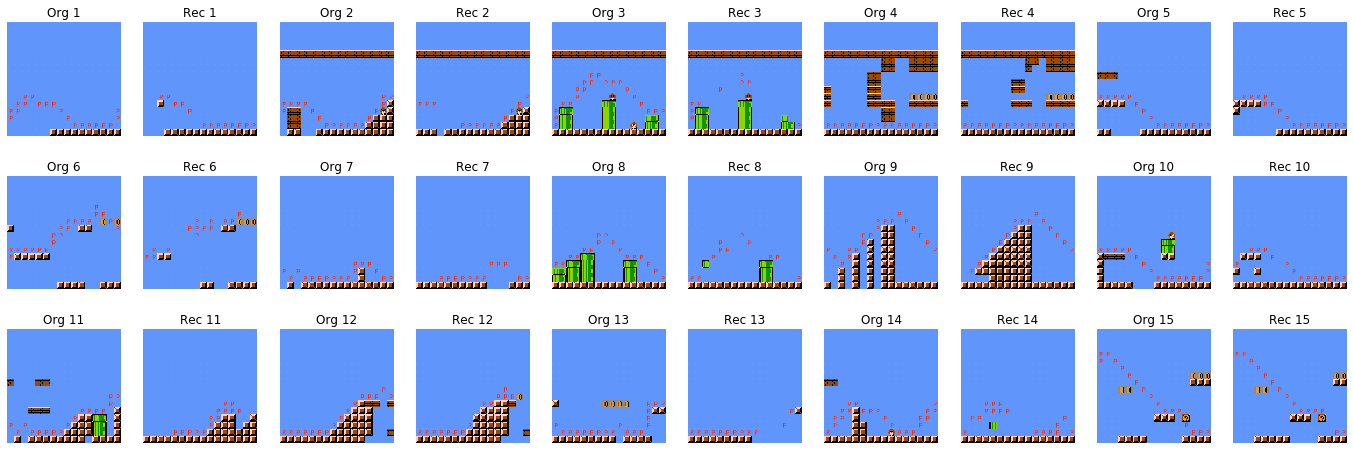

In [111]:
fig, axes = plt.subplots(nrows=3, ncols=10, figsize=(24, 8))
axes = axes.flatten()
nrows, ncols = 3, 10

org_idxs = np.arange(0, 29, 2)
rec_idxs = org_idxs + 1

for idx in org_idxs:
        
    ax = axes[idx]

    ax.imshow(np.asarray(org_images[idx // 2]))
    ax.set_title(f'Org {idx // 2 + 1}')
    
    ax.axis('off')

for idx in rec_idxs:
        
    ax = axes[idx]

    ax.imshow(np.asarray(rec_images[idx // 2]))
    ax.set_title(f'Rec {idx // 2 + 1}')

    ax.axis('off')
    
plt.show()

## Random Generation per Category

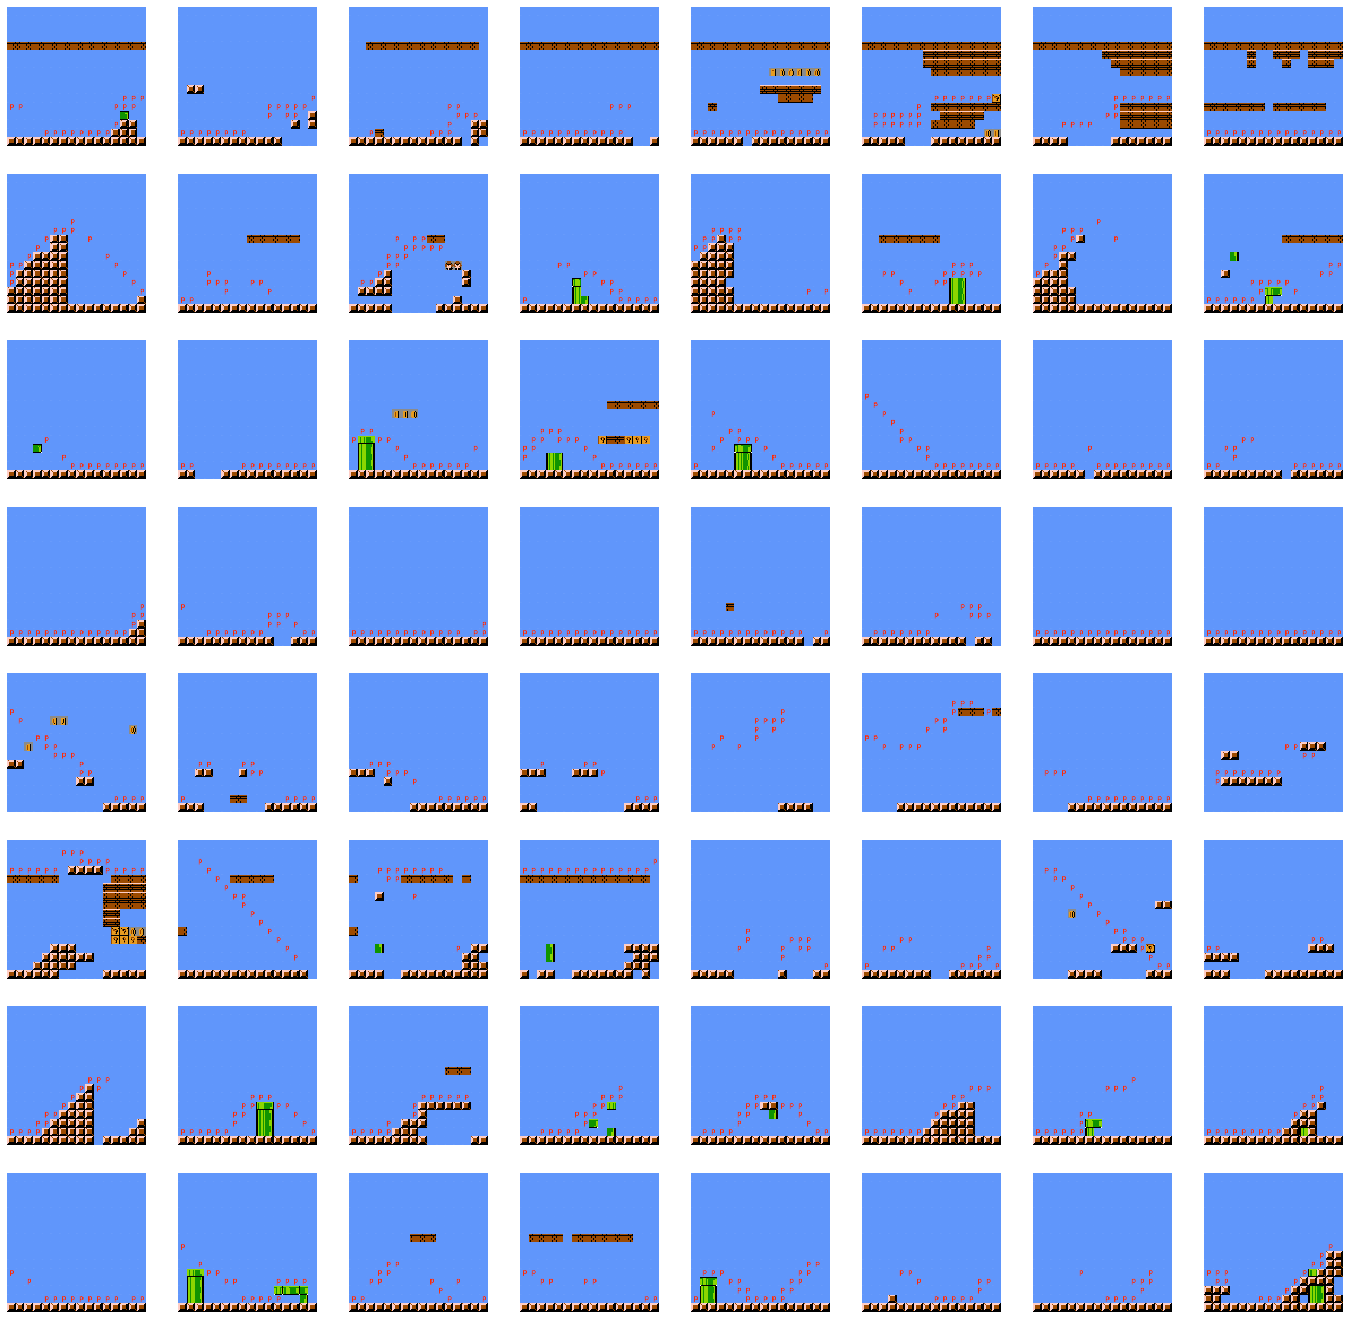

In [112]:
def display_random_generation(generated, num_classes, n=10):
    plt.figure(figsize=[24,24])
    for c in range(num_classes):
        for i in range(n):
            plt.subplot(num_classes, n, (c * n) + i + 1)
            chunk_int = generated[(c * n) + i].reshape(16, 16, 12).argmax(axis=-1)
            chunk_pix = vglc_with_path_encodings.array_to_image([chunk_int], game='smba')[0]
            plt.imshow(chunk_pix)
            plt.gray()
            plt.axis('off')
    plt.show()

elem_per_category = 8
generated = gmvae.random_generation(elem_per_category)
display_random_generation(generated, args.num_classes, elem_per_category)

In [113]:
elem_per_category = 10000 // 8
generated = gmvae.random_generation(elem_per_category)

In [114]:
generated_int = generated.reshape(-1, 16, 16, 12).argmax(axis=-1)

In [115]:
generated_int.shape

(10000, 16, 16)

In [94]:
# since this code chunk depends on random seed, it shouldn't be run again
# with open('../smba_generations/smba_gmvae_8.json', 'w+') as json_f:
#     json.dump(generated_int.tolist(), json_f)

## Visualization of the feature latent space

In [18]:
# get feature representations
test_features, test_labels = gmvae.latent_features(train_dl, return_learned_labels=True)

In [19]:
np.bincount(test_labels)

array([150, 258, 270, 445, 431, 201, 335, 338])

In [117]:
# import TSNE from scikit-learn library
from sklearn.manifold import TSNE

# reduce dimensionality to 2D, we consider a subset of data because TSNE
# is a slow algorithm

first_n = 1000
tsne_features = TSNE(n_components=2).fit_transform(test_features[:first_n])

In [118]:
test_labels_subset = test_labels[:first_n]

In [119]:
X_, Y_ = np.s_[:,0], np.s_[:,1]

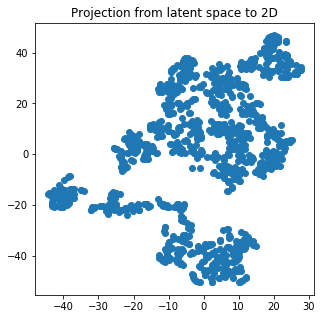

In [120]:
fig = plt.figure(figsize=(5, 5))

plt.scatter(tsne_features[X_], tsne_features[Y_])

plt.title('Projection from latent space to 2D')
plt.show()